# ENERGY MANAGEMENT : CUBIC BUILDING 

Hélène DEMECH /
Louis-Vincent DESMIER /
Agathe FARJON /
Fanny HEBERT /

Date: March 2023

This is the result of a study made during the Energy Management course at INSA Lyon, engineering school, in the department of Civil Engineering and Urban Planning.
The study was conducted under the supervision of professor Christian Ghiaus by Helene Demech, Louis-Vincent Desmier, Agathe Farjon and Fanny Hebert, four students in fourth year at INSA Lyon.

This file is available on github : https://github.com/LVDesmier/CubicBuildingThermalAnalysis and can be run interactively on Binder : https://mybinder.org/v2/gh/LVDesmier/CubicBuildingThermalAnalysis/HEAD

The study was made over original code 03CubicBuilding.ipynb from Christian Ghiaus available in the repository https://github.com/cghiaus/dm4bem and on Binder https://mybinder.org/v2/gh/cghiaus/dm4bem/HEAD

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

# Description of the building

![cube](./figures/03_cube_principle.png)
> Figure 1. Simple ventilated room (5 two-layer walls and 1 glass window) equiped with an HVAC system which acts as a proportional controller.

Let’s consider a cubic building with an HVAC systems acting as a [proportional controller](https://en.m.wikipedia.org/wiki/Proportional_control).

The dimensions and surface areas of the building are:
- $l=3 \: \mathrm{m}$ - edge length of the cube;
- $S_g=l^2$   - surface area of the glass window;
- $S_c = S_i = 5 \times S_g$   - surface area of the 5 (concrete and insulation) walls.

In [2]:
l = 3               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls

The thermophysical properties of the air (in SI units) are:

In [3]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


The thermophysical properties and the surface areas of the three materials (i.e., concrete, insulation, glass) in SI units are:

In [4]:
wall = {'Conductivity': [1.4, 0.027, 1.4],  # W/(m·K)
        'Density': [2300, 55, 2500],        # kg/m³
        'Specific heat': [880, 1210, 750],  # J/(kg·K)
        'Width': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
        'Slices': [1, 1, 1]}                # number of  slices
wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
wall

,Conductivity,Density,Specific heat,Width,Surface,Slices
Concrete,1.400,2300,880,0.200,45,1
Insulation,0.027,55,1210,0.080,45,1
Glass,1.400,2500,750,0.004,9,1


The radiative properties of surface, view factors and convections coefficients are:

In [5]:
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

Fwg = 1 / 5     # view factor wall - glass

h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,8.0,25


# Thermal circuit

We made some hypothesis:

Heat transfert is:
- through the walls (concrete and insulation), 
- through the glass window,
- by ventilation,
- from indoor auxiliary sources,
- from the HVAC system.

The HVAC system is modelled as a proportional controller. There is long wave radiative exchange between the wall and the glass window. The sources are:
- temperature sources:
    - outdoor atmospheric air;
    - indoor air temperature setpoint;
- flow rate sources:
    - solar radiation on the outdoor and the indoor walls;
    - auxiliary heat gains in the thermal zone.

![heat_processes](./figures/03_heat_process.png)
> Figure 2. Heat processes for the cubic building shown in Figure 1.

![thermal_circuit](./figures/03_therm_circ.png)
> Figure 3. Thermal circuit for the cubic building shown in Figure 1 and the heat processes shown in Figure 2. *Note*: space discretization of the walls is done for simplicity.

Figure 3 shows the models of:
- concrete & insulation wall: in red;
- glass window: in green;
- ventilation: in magenta;
- indoor volume: in blue (conductances 6 & 7 for convection; conductance 5 for long wave radiation between the walls and the glass window);
- HVAC system: in black.

The sources are:
- $T_o$ - outdoor temperature, °C;
- $T_{i,sp}$ - setpoint temperaure for the indoor air, °C;
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
- $\Phi_a$ - solar radiation absorbed by the glass, W.


*Note*: The known values, i.e. the elements of the circuit (the conductances $G$ and capacities $C$) and the sources (of temperature $T$ and of flow rate $\Phi$ or $\dot{Q}$) are noted in uppercase (majuscule) letters. The unknow variables, i.e. the temperatures in the nodes $\theta$ and the flow rates on the branches $q$, are noted in lowercase (minuscule) letters.

In [6]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Concrete,315.0000
Insulation,15.1875
Glass,3150.0000


In [7]:
# Convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

In [8]:
# Long wave radiation

Tm = 20 + 273   # K, mean temp for radiative exchange
GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

In [9]:
# Advection
Va = l**3                   # m³ volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s air infiltration

# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

In [10]:
# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0
Kp = 0

In [11]:
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

In [12]:
# Thermal capacities
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns={'Capacity'})

,Capacity
Concrete,18216000.0
Insulation,239580.0
Glass,67500.0
Air,32400.0


# Mathematical model

## System of algebraic-differential equations (DAE)

### A : incidence matrix

In [13]:
A = np.zeros([12, 8])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6
np.set_printoptions(suppress=False)
pd.DataFrame(A)

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0


### G: Conductance matrix

In [14]:
G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
             2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
             GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
             2 * G_cd['Glass'], Gv, Kp])
np.set_printoptions(precision=3, threshold=16, suppress=True)
pd.set_option("display.precision", 1)
pd.DataFrame(G)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,630.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,630.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,30.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,30.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,44.8,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,217.2,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6300.0,0.0,0.0


### C: Capacity matrix

In [15]:
C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
            C['Air'], C['Glass']])
# Uncomment next line to put 'Air' and 'Glass' capacities to zero 
# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
pd.set_option("display.precision", 3)
pd.DataFrame(C)

,0,1,2,3,4,5,6,7
0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.822e+07,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000e+00,0.0,239580.0,0.0,0.0,0.0,0.0
4,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000e+00,0.0,0.0,0.0,0.0,32400.0,0.0
7,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,67500.0


### b: Temperature source vector

In [16]:
b = np.zeros(12)        # branches
b[[0, 8, 10, 11]] = 1   # branches with temperature sources
print(f'b = ', b)

b =  [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]


### f: Heat flow source vector

In [17]:
f = np.zeros(8)         # nodes
f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 0. 0. 0. 1. 0. 1. 1.]


### y: output vector


In [18]:
y = np.zeros(8)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 0. 0. 0. 0. 1. 0.]


## State-space representation

In [19]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-0.     0.     0.     0.   ]
 [ 0.    -0.     0.     0.   ]
 [ 0.     0.001 -0.004  0.003]
 [ 0.     0.     0.002 -0.005]] 

Bs = 
 [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.003 0.    ... 0.    0.    0.   ]] 

Cs = 
 [[0. 0. 1. 0.]] 

Ds = 
 [[0. 0. 0. 0. 0. 0. 0. 0.]] 



# Steady state results

In [20]:
b = np.zeros(12)        # temperature sources
b[[0, 8, 10]] = 10      # outdoor temperature
b[[11]] = 20            # indoor set-point temperature

f = np.zeros(8)         # flow-rate sources

In [21]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C


In [22]:
bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 10 10 20  0  0  0  0]


The steady-state value of the output of the state-space representation is:

In [23]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')
print(f'Max error between DAE and state-space: \
{max(abs(θ[6] - yss)):.2e} °C')

yss = [10.] °C
Max error between DAE and state-space: 8.88e-15 °C


# Dynamic simulation results

In [24]:
# Time step
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = min(-2. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

dt = 4 * 60     # seconds
print(f'dt = {dt} s = {dt / 60:.0f} min')

Time constants: 
 [43971.968  4752.052   429.663   144.61 ] s 

2 x Time constants: 
 [87943.936  9504.104   859.327   289.22 ] s 

Maximum time step: 289.22 s = 4.82 min
dt = 240 s = 4 min


In [25]:
# Settling time
t_resp = 4 * max(-1 / λ)
print('Time constants: \n', -1 / λ, 's \n')
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

Time constants: 
 [43971.968  4752.052   429.663   144.61 ] s 

Settling time: 175888 s = 2931.5 min = 48.86 h = 2.04 days


In [26]:
# Duration
duration = 3600 * 24 * 2            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

Duration = 172800 s
Number of time steps = 720


,time
0,0
1,240
2,480
3,720
4,960
...,...
715,171600
716,171840
717,172080
718,172320


In [27]:
# Input vector

u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


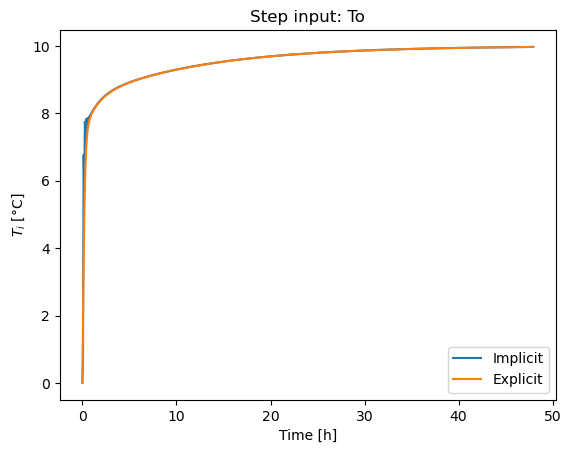

In [28]:
# Time integration
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])
    
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax.legend(['Implicit', 'Explicit'])
plt.show()

> Figure 4: Step response to outdoor temperature by using Euler (without modify the duration of simulation)

In [29]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 9.9686 °C


## Simulation with weather data

In [30]:
start_date = '2000-01-03 12:00:00'
end_date = '2000-01-03 18:00:00'

print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-01-03 12:00:00 	start date
2000-01-03 18:00:00 	end date


In [31]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(
    weather.index >= start_date) & (
    weather.index < end_date)]

surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)

rad_surf['Etot'] = rad_surf.sum(axis=1)

data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])

To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
pd.DataFrame(u)

,To,To,To,Ti,Φo,Φi,Qa,Φa
2000-01-03 12:00:00+01:00,6.800,6.800,6.800,20.0,1113.183,66.791,0.0,338.408
2000-01-03 12:04:00+01:00,6.880,6.880,6.880,20.0,1167.494,70.050,0.0,354.918
2000-01-03 12:08:00+01:00,6.960,6.960,6.960,20.0,1221.805,73.308,0.0,371.429
2000-01-03 12:12:00+01:00,7.040,7.040,7.040,20.0,1276.116,76.567,0.0,387.939
2000-01-03 12:16:00+01:00,7.120,7.120,7.120,20.0,1330.428,79.826,0.0,404.450
...,...,...,...,...,...,...,...,...
2000-01-03 16:44:00+01:00,6.533,6.533,6.533,20.0,39.900,2.394,0.0,12.130
2000-01-03 16:48:00+01:00,6.400,6.400,6.400,20.0,29.925,1.795,0.0,9.097
2000-01-03 16:52:00+01:00,6.267,6.267,6.267,20.0,19.950,1.197,0.0,6.065
2000-01-03 16:56:00+01:00,6.133,6.133,6.133,20.0,9.975,0.598,0.0,3.032


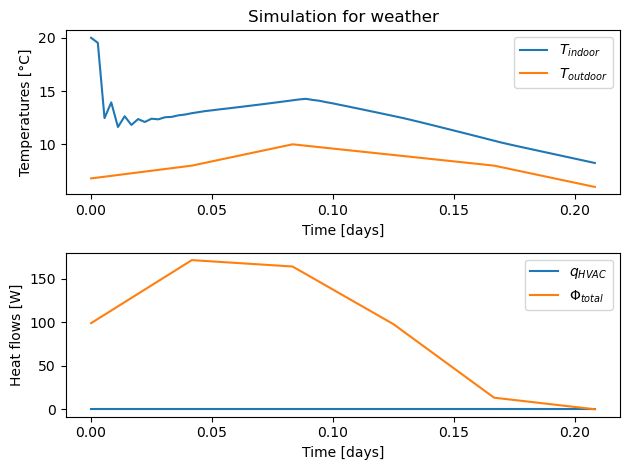

In [32]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]]) # initial conditions

# Time integration
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]
    
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [days]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 5. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

# Analyse of the dynamic model 

## Definition of functions for treatment

In [33]:
def code(duration) :
    
    l = 3               
    # m length of the cubic room
    Sg = l**2           # m² surface of the glass wall
    Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls
    air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
    # pd.DataFrame.from_dict(air, orient='index', columns=['air'])
    #pd.DataFrame(air, index=['Air'])

    wall = {'Conductivity': [1.4, 0.027, 1.4],  # W/(m·K)
            'Density': [2300, 55, 2500],        # kg/m³
            'Specific heat': [1000, 1210, 750],  # J/(kg·K)
            'Width': [0.2, 0.08, 0.004],
            'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
            'Slices': [1, 1, 1]}                # number of  slices
    wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
    wall
    ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
    ε_gLW = 0.90    # long wave emmisivity: glass pyrex
    α_wSW = 0.25    # short wave absortivity: white smooth surface
    α_gSW = 0.38    # short wave absortivity: reflective blue glass
    τ_gSW = 0.30    # short wave transmitance: reflective blue glass
    σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
    #print(f'σ = {σ} W/(m²⋅K⁴)')
    Fwg = 1 / 5     # view factor wall - glass
    h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
    # Conduction
    G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
    pd.DataFrame(G_cd, columns={'Conductance'})

    # Convection
    Gw = h * wall['Surface'][0]     # wall
    Gg = h * wall['Surface'][2]     # glass
    Tm = 20 + 273   # K, mean temp for radiative exchange

    GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']
    GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
    GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
    GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)
    Va = l**3                   # m³ volume of air
    ACH = 1                     # air changes per hour
    Va_dot = ACH / 3600 * Va    # m³/s air infiltration
    # ventilation & advection
    Gv = air['Density'] * air['Specific heat'] * Va_dot
    # P-controler gain
    Kp = 1e4            # almost perfect controller Kp -> ∞
    Kp = 1e-3           # no controller Kp -> 0
    Kp = 0
    # glass: convection outdoor & conduction
    Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))
    C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
    C['Air'] = air['Density'] * air['Specific heat'] * Va
    #pd.DataFrame(C, columns={'Capacity'})

    A = np.zeros([12, 8])       # n° of branches X n° of nodes
    A[0, 0] = 1                 # branch 0: -> node 0
    A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
    A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
    A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
    A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
    A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
    A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
    A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
    A[8, 7] = 1                 # branch 8: -> node 7
    A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
    A[10, 6] = 1                # branch 10: -> node 6
    A[11, 6] = 1                # branch 11: -> node 6
    np.set_printoptions(suppress=False)
    #pd.DataFrame(A)
    G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
                 2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
                 GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
                 2 * G_cd['Glass'], Gv, Kp])
    np.set_printoptions(precision=3, threshold=16, suppress=True)
    pd.set_option("display.precision", 1)
    #pd.DataFrame(G)
    C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
                C['Air'], C['Glass']])
    # Uncomment next line to put 'Air' and 'Glass' capacities to zero 
    # C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
    pd.set_option("display.precision", 3)
    #pd.DataFrame(C)

    b = np.zeros(12)        # branches
    b[[0, 8, 10, 11]] = 1   # branches with temperature sources
    #print(f'b = ', b)

    f = np.zeros(8)         # nodes
    f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources
    #print(f'f = ', f)

    y = np.zeros(8)         # nodes
    y[[6]] = 1              # nodes (temperatures) of interest
    #print(f'y = ', y)

    [As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
    #print('As = \n', As, '\n')
    #print('Bs = \n', Bs, '\n')
    #print('Cs = \n', Cs, '\n')
    #print('Ds = \n', Ds, '\n')

    b = np.zeros(12)        # temperature sources
    b[[0, 8, 10]] = 10      # outdoor temperature
    b[[11]] = 20            # indoor set-point temperature

    f = np.zeros(8)         # flow-rate sources

    θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
    print(f'θ = {θ} °C')

    bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
    fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
    u = np.hstack([bT, fQ])
    #print(f'u = {u}')

    yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
    print(f'yss = {yss} °C')

    print(f'Max error between DAE and state-space: \
    {max(abs(θ[6] - yss)):.2e} °C')

    λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
    print('Time constants: \n', -1 / λ, 's \n')
    print('2 x Time constants: \n', -2 / λ, 's \n')
    dtmax = min(-2. / λ)
    print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

    dt = 4 * 60     # seconds
    print(f'dt = {dt} s = {dt / 60:.0f} min')

    t_resp = 4 * max(-1 / λ)
    print('Time constants: \n', -1 / λ, 's \n')
    print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
    = {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

    duration = duration                 # seconds, larger than response time
    n = int(np.floor(duration / dt))    # number of time steps
    t = np.arange(0, n * dt, dt)        # time vector for n time steps
    start_date = '2000-01-03 12:00:00'
    end_date = '2000-01-03 18:00:00'

    print(f'Duration = {duration} s')
    print(f'Number of time steps = {n}')
    #pd.DataFrame(t, columns=['time'])

    u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
    u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
    u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
    print('u = ')
    #pd.DataFrame(u)

    n_s = As.shape[0]                      # number of state variables
    θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
    θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

    I = np.eye(n_s)                        # identity matrix

    for k in range(n - 1):
        θ_exp[:, k + 1] = (I + dt * As) @\
            θ_exp[:, k] + dt * Bs @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
            (θ_imp[:, k] + dt * Bs @ u[:, k])

    y_exp = Cs @ θ_exp + Ds @  u
    y_imp = Cs @ θ_imp + Ds @  u

    fig, ax = plt.subplots()
    ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
    ax.set(xlabel='Time [h]',
           ylabel='$T_i$ [°C]',
           title='Step input: To')
    ax.legend(['Implicit', 'Explicit'])
    plt.show()

    filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
    [data, meta] = dm4bem.read_epw(filename, coerce_year=None)
    weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
    del data

    weather.index = weather.index.map(lambda t: t.replace(year=2000))
    weather = weather[(
        weather.index >= start_date) & (
        weather.index < end_date)]

    #pd.DataFrame(weather)

    surface_orientation = {'slope': 90,
                           'azimuth': 0,
                           'latitude': 45}
    albedo = 0.2
    rad_surf = dm4bem.sol_rad_tilt_surf(
        weather, surface_orientation, albedo)
    #pd.DataFrame(rad_surf)

    rad_surf['Etot'] = rad_surf.sum(axis=1)

    data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
    data = data.resample(str(dt) + 'S').interpolate(method='linear')
    data = data.rename(columns={'temp_air': 'To'})
    #pd.DataFrame(data)

    data['Ti'] = 20 * np.ones(data.shape[0])
    data['Qa'] = 0 * np.ones(data.shape[0])
    #pd.DataFrame(data)

    To = data['To']
    Ti = data['Ti']
    Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']
    Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
    Qa = data['Qa']
    Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

    u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
    u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
    #pd.DataFrame(u)

    θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
            + dt * Bs @ u.iloc[k, :]
    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC = Kp * (data['Ti'] - y_exp[0, :])
    t = dt * np.arange(data.shape[0])   # time vector

    fig, axs = plt.subplots(2, 1)
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')

    # plot total solar radiation and HVAC heat flow
    axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
    axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
    axs[1].set(xlabel='Time [days]',
               ylabel='Heat flows [W]')
    axs[1].legend(loc='upper right')



    return plt.show(), print(f'- DAE model: {float(θ[6]):.4f} °C'), print(f'- state-space model: {float(yss):.4f} °C'), print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C'), print(f'{start_date} \tstart date'), print(f'{end_date} \tend date'), fig.tight_layout()

In [34]:
def code2(dt) :
    
    l = 3               
    # m length of the cubic room
    Sg = l**2           # m² surface of the glass wall
    Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls
    air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
    # pd.DataFrame.from_dict(air, orient='index', columns=['air'])
    #pd.DataFrame(air, index=['Air'])

    wall = {'Conductivity': [1.4, 0.027, 1.4],  # W/(m·K)
            'Density': [2300, 55, 2500],        # kg/m³
            'Specific heat': [1000, 1210, 750],  # J/(kg·K)
            'Width': [0.2, 0.08, 0.004],
            'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
            'Slices': [1, 1, 1]}                # number of  slices
    wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
    wall
    ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
    ε_gLW = 0.90    # long wave emmisivity: glass pyrex
    α_wSW = 0.25    # short wave absortivity: white smooth surface
    α_gSW = 0.38    # short wave absortivity: reflective blue glass
    τ_gSW = 0.30    # short wave transmitance: reflective blue glass
    σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
    #print(f'σ = {σ} W/(m²⋅K⁴)')
    Fwg = 1 / 5     # view factor wall - glass
    h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
    # Conduction
    G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
    pd.DataFrame(G_cd, columns={'Conductance'})

    # Convection
    Gw = h * wall['Surface'][0]     # wall
    Gg = h * wall['Surface'][2]     # glass
    Tm = 20 + 273   # K, mean temp for radiative exchange

    GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']
    GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
    GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
    GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)
    Va = l**3                   # m³ volume of air
    ACH = 1                     # air changes per hour
    Va_dot = ACH / 3600 * Va    # m³/s air infiltration
    # ventilation & advection
    Gv = air['Density'] * air['Specific heat'] * Va_dot
    # P-controler gain
    Kp = 1e4            # almost perfect controller Kp -> ∞
    Kp = 1e-3           # no controller Kp -> 0
    Kp = 0
    # glass: convection outdoor & conduction
    Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))
    C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
    C['Air'] = air['Density'] * air['Specific heat'] * Va
    #pd.DataFrame(C, columns={'Capacity'})

    A = np.zeros([12, 8])       # n° of branches X n° of nodes
    A[0, 0] = 1                 # branch 0: -> node 0
    A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
    A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
    A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
    A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
    A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
    A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
    A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
    A[8, 7] = 1                 # branch 8: -> node 7
    A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
    A[10, 6] = 1                # branch 10: -> node 6
    A[11, 6] = 1                # branch 11: -> node 6
    np.set_printoptions(suppress=False)
    #pd.DataFrame(A)
    G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
                 2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
                 GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
                 2 * G_cd['Glass'], Gv, Kp])
    np.set_printoptions(precision=3, threshold=16, suppress=True)
    pd.set_option("display.precision", 1)
    #pd.DataFrame(G)
    C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
                C['Air'], C['Glass']])
    # Uncomment next line to put 'Air' and 'Glass' capacities to zero 
    # C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
    pd.set_option("display.precision", 3)
    #pd.DataFrame(C)

    b = np.zeros(12)        # branches
    b[[0, 8, 10, 11]] = 1   # branches with temperature sources
    #print(f'b = ', b)

    f = np.zeros(8)         # nodes
    f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources
    #print(f'f = ', f)

    y = np.zeros(8)         # nodes
    y[[6]] = 1              # nodes (temperatures) of interest
    #print(f'y = ', y)

    [As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
    #print('As = \n', As, '\n')
    #print('Bs = \n', Bs, '\n')
    #print('Cs = \n', Cs, '\n')
    #print('Ds = \n', Ds, '\n')

    b = np.zeros(12)        # temperature sources
    b[[0, 8, 10]] = 10      # outdoor temperature
    b[[11]] = 20            # indoor set-point temperature

    f = np.zeros(8)         # flow-rate sources

    θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
    print(f'θ = {θ} °C')

    bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
    fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
    u = np.hstack([bT, fQ])
    #print(f'u = {u}')

    yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
    print(f'yss = {yss} °C')

    print(f'Max error between DAE and state-space: \
    {max(abs(θ[6] - yss)):.2e} °C')

    λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
    print('Time constants: \n', -1 / λ, 's \n')
    print('2 x Time constants: \n', -2 / λ, 's \n')
    dtmax = min(-2. / λ)
    print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

    dt = dt    # seconds
    print(f'dt = {dt} s = {dt / 60:.0f} min')

    t_resp = 4 * max(-1 / λ)
    print('Time constants: \n', -1 / λ, 's \n')
    print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
    = {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

    duration = 3600 * 24 * 2            # seconds, larger than response time
    n = int(np.floor(duration / dt))    # number of time steps
    t = np.arange(0, n * dt, dt)        # time vector for n time steps
    start_date = '2000-01-03 12:00:00'
    end_date = '2000-01-04 12:00:00'

    print(f'Duration = {duration} s')
    print(f'Number of time steps = {n}')
    #pd.DataFrame(t, columns=['time'])

    u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
    u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
    u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
    print('u = ')
    #pd.DataFrame(u)

    n_s = As.shape[0]                      # number of state variables
    θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
    θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

    I = np.eye(n_s)                        # identity matrix

    for k in range(n - 1):
        θ_exp[:, k + 1] = (I + dt * As) @\
            θ_exp[:, k] + dt * Bs @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
            (θ_imp[:, k] + dt * Bs @ u[:, k])

    y_exp = Cs @ θ_exp + Ds @  u
    y_imp = Cs @ θ_imp + Ds @  u

    fig, ax = plt.subplots()
    ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
    ax.set(xlabel='Time [h]',
           ylabel='$T_i$ [°C]',
           title='Step input: To')
    ax.legend(['Implicit', 'Explicit'])
    plt.show()

    filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
    [data, meta] = dm4bem.read_epw(filename, coerce_year=None)
    weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
    del data

    weather.index = weather.index.map(lambda t: t.replace(year=2000))
    weather = weather[(
        weather.index >= start_date) & (
        weather.index < end_date)]

    #pd.DataFrame(weather)

    surface_orientation = {'slope': 90,
                           'azimuth': 0,
                           'latitude': 45}
    albedo = 0.2
    rad_surf = dm4bem.sol_rad_tilt_surf(
        weather, surface_orientation, albedo)
    #pd.DataFrame(rad_surf)

    rad_surf['Etot'] = rad_surf.sum(axis=1)

    data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
    data = data.resample(str(dt) + 'S').interpolate(method='linear')
    data = data.rename(columns={'temp_air': 'To'})
    #pd.DataFrame(data)

    data['Ti'] = 20 * np.ones(data.shape[0])
    data['Qa'] = 0 * np.ones(data.shape[0])
    #pd.DataFrame(data)

    To = data['To']
    Ti = data['Ti']
    Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']
    Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
    Qa = data['Qa']
    Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

    u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
    u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
    #pd.DataFrame(u)

    θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
            + dt * Bs @ u.iloc[k, :]
    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC = Kp * (data['Ti'] - y_exp[0, :])
    t = dt * np.arange(data.shape[0])   # time vector

    fig, axs = plt.subplots(2, 1)
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')

    # plot total solar radiation and HVAC heat flow
    axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
    axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
    axs[1].set(xlabel='Time [days]',
               ylabel='Heat flows [W]')
    axs[1].legend(loc='upper right')

    return plt.show(), print(f'- DAE model: {float(θ[6]):.4f} °C'), print(f'- state-space model: {float(yss):.4f} °C'), print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C'), print(f'{start_date} \tstart date'), print(f'{end_date} \tend date'), fig.tight_layout()

In [35]:
def code3(dt) :
    
    l = 3               
    # m length of the cubic room
    Sg = l**2           # m² surface of the glass wall
    Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls
    air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
    # pd.DataFrame.from_dict(air, orient='index', columns=['air'])
    #pd.DataFrame(air, index=['Air'])

    wall = {'Conductivity': [1.4, 0.027, 1.4],  # W/(m·K)
            'Density': [2300, 55, 2500],        # kg/m³
            'Specific heat': [1000, 1210, 750],  # J/(kg·K)
            'Width': [0.2, 0.08, 0.004],
            'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
            'Slices': [1, 1, 1]}                # number of  slices
    wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
    wall
    ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
    ε_gLW = 0.90    # long wave emmisivity: glass pyrex
    α_wSW = 0.25    # short wave absortivity: white smooth surface
    α_gSW = 0.38    # short wave absortivity: reflective blue glass
    τ_gSW = 0.30    # short wave transmitance: reflective blue glass
    σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
    #print(f'σ = {σ} W/(m²⋅K⁴)')
    Fwg = 1 / 5     # view factor wall - glass
    h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
    # Conduction
    G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
    pd.DataFrame(G_cd, columns={'Conductance'})

    # Convection
    Gw = h * wall['Surface'][0]     # wall
    Gg = h * wall['Surface'][2]     # glass
    Tm = 20 + 273   # K, mean temp for radiative exchange

    GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']
    GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
    GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
    GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)
    Va = l**3                   # m³ volume of air
    ACH = 1                     # air changes per hour
    Va_dot = ACH / 3600 * Va    # m³/s air infiltration
    # ventilation & advection
    Gv = air['Density'] * air['Specific heat'] * Va_dot
    # P-controler gain
    Kp = 1e4            # almost perfect controller Kp -> ∞
    Kp = 1e-3           # no controller Kp -> 0
    Kp = 0
    # glass: convection outdoor & conduction
    Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))
    C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
    C['Air'] = air['Density'] * air['Specific heat'] * Va
    #pd.DataFrame(C, columns={'Capacity'})

    A = np.zeros([12, 8])       # n° of branches X n° of nodes
    A[0, 0] = 1                 # branch 0: -> node 0
    A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
    A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
    A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
    A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
    A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
    A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
    A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
    A[8, 7] = 1                 # branch 8: -> node 7
    A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
    A[10, 6] = 1                # branch 10: -> node 6
    A[11, 6] = 1                # branch 11: -> node 6
    np.set_printoptions(suppress=False)
    #pd.DataFrame(A)
    G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
                 2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
                 GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
                 2 * G_cd['Glass'], Gv, Kp])
    np.set_printoptions(precision=3, threshold=16, suppress=True)
    pd.set_option("display.precision", 1)
    #pd.DataFrame(G)
    # C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
    #            C['Air'], C['Glass']])
    # Uncomment next line to put 'Air' and 'Glass' capacities to zero 
    C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
    pd.set_option("display.precision", 3)
    #pd.DataFrame(C)

    b = np.zeros(12)        # branches
    b[[0, 8, 10, 11]] = 1   # branches with temperature sources
    #print(f'b = ', b)

    f = np.zeros(8)         # nodes
    f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources
    #print(f'f = ', f)

    y = np.zeros(8)         # nodes
    y[[6]] = 1              # nodes (temperatures) of interest
    #print(f'y = ', y)

    [As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
    #print('As = \n', As, '\n')
    #print('Bs = \n', Bs, '\n')
    #print('Cs = \n', Cs, '\n')
    #print('Ds = \n', Ds, '\n')

    b = np.zeros(12)        # temperature sources
    b[[0, 8, 10]] = 10      # outdoor temperature
    b[[11]] = 20            # indoor set-point temperature

    f = np.zeros(8)         # flow-rate sources

    θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
    print(f'θ = {θ} °C')

    bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
    fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
    u = np.hstack([bT, fQ])
    #print(f'u = {u}')

    yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
    print(f'yss = {yss} °C')

    print(f'Max error between DAE and state-space: \
    {max(abs(θ[6] - yss)):.2e} °C')

    λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
    print('Time constants: \n', -1 / λ, 's \n')
    print('2 x Time constants: \n', -2 / λ, 's \n')
    dtmax = min(-2. / λ)
    print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

    dt = dt     # seconds
    print(f'dt = {dt} s = {dt / 60:.0f} min')

    t_resp = 4 * max(-1 / λ)
    print('Time constants: \n', -1 / λ, 's \n')
    print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
    = {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

    duration = 3600 * 24 * 2            # seconds, larger than response time
    n = int(np.floor(duration / dt))    # number of time steps
    t = np.arange(0, n * dt, dt)        # time vector for n time steps
    start_date = '2000-01-03 12:00:00'
    end_date = '2000-01-04 12:00:00'

    print(f'Duration = {duration} s')
    print(f'Number of time steps = {n}')
    #pd.DataFrame(t, columns=['time'])

    u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
    u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
    u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
    print('u = ')
    #pd.DataFrame(u)

    n_s = As.shape[0]                      # number of state variables
    θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
    θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

    I = np.eye(n_s)                        # identity matrix

    for k in range(n - 1):
        θ_exp[:, k + 1] = (I + dt * As) @\
            θ_exp[:, k] + dt * Bs @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
            (θ_imp[:, k] + dt * Bs @ u[:, k])

    y_exp = Cs @ θ_exp + Ds @  u
    y_imp = Cs @ θ_imp + Ds @  u

    fig, ax = plt.subplots()
    ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
    ax.set(xlabel='Time [h]',
           ylabel='$T_i$ [°C]',
           title='Step input: To')
    ax.legend(['Implicit', 'Explicit'])
    plt.show()

    filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
    [data, meta] = dm4bem.read_epw(filename, coerce_year=None)
    weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
    del data

    weather.index = weather.index.map(lambda t: t.replace(year=2000))
    weather = weather[(
        weather.index >= start_date) & (
        weather.index < end_date)]

    #pd.DataFrame(weather)

    surface_orientation = {'slope': 90,
                           'azimuth': 0,
                           'latitude': 45}
    albedo = 0.2
    rad_surf = dm4bem.sol_rad_tilt_surf(
        weather, surface_orientation, albedo)
    #pd.DataFrame(rad_surf)

    rad_surf['Etot'] = rad_surf.sum(axis=1)

    data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
    data = data.resample(str(dt) + 'S').interpolate(method='linear')
    data = data.rename(columns={'temp_air': 'To'})
    #pd.DataFrame(data)

    data['Ti'] = 20 * np.ones(data.shape[0])
    data['Qa'] = 0 * np.ones(data.shape[0])
    #pd.DataFrame(data)

    To = data['To']
    Ti = data['Ti']
    Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']
    Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
    Qa = data['Qa']
    Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

    u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
    u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
    #pd.DataFrame(u)

    θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
            + dt * Bs @ u.iloc[k, :]
    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC = Kp * (data['Ti'] - y_exp[0, :])
    t = dt * np.arange(data.shape[0])   # time vector

    fig, axs = plt.subplots(2, 1)
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')

    # plot total solar radiation and HVAC heat flow
    axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
    axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
    axs[1].set(xlabel='Time [days]',
               ylabel='Heat flows [W]')
    axs[1].legend(loc='upper right')

    return plt.show(), print(f'- DAE model: {float(θ[6]):.4f} °C'), print(f'- state-space model: {float(yss):.4f} °C'), print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C'), print(f'{start_date} \tstart date'), print(f'{end_date} \tend date'), fig.tight_layout()

In [36]:
def material(Conduct, Dens, Spec_heat, Emiss) :
    
    l = 3               
    # m length of the cubic room
    Sg = l**2           # m² surface of the glass wall
    Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls
    air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
    # pd.DataFrame.from_dict(air, orient='index', columns=['air'])
    #pd.DataFrame(air, index=['Air'])

    wall = {'Conductivity': [Conduct, 0.027, 1.4],  # W/(m·K)
            'Density': [Dens, 55, 2500],        # kg/m³
            'Specific heat': [Spec_heat, 1210, 750],  # J/(kg·K)
            'Width': [0.2, 0.08, 0.004],
            'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
            'Slices': [1, 1, 1]}                # number of  slices
    wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
    wall
    ε_wLW = Emiss    # long wave emmisivity: wall surface (material choosen)
    ε_gLW = 0.90    # long wave emmisivity: glass pyrex
    α_wSW = 0.25    # short wave absortivity: white smooth surface
    α_gSW = 0.38    # short wave absortivity: reflective blue glass
    τ_gSW = 0.30    # short wave transmitance: reflective blue glass
    σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
    #print(f'σ = {σ} W/(m²⋅K⁴)')
    Fwg = 1 / 5     # view factor wall - glass
    h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
    # Conduction
    G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
    pd.DataFrame(G_cd, columns={'Conductance'})

    # Convection
    Gw = h * wall['Surface'][0]     # wall
    Gg = h * wall['Surface'][2]     # glass
    Tm = 20 + 273   # K, mean temp for radiative exchange

    GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']
    GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
    GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
    GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)
    Va = l**3                   # m³ volume of air
    ACH = 1                     # air changes per hour
    Va_dot = ACH / 3600 * Va    # m³/s air infiltration
    # ventilation & advection
    Gv = air['Density'] * air['Specific heat'] * Va_dot
    # P-controler gain
    Kp = 1e4            # almost perfect controller Kp -> ∞
    Kp = 1e-3           # no controller Kp -> 0
    Kp = 0
    # glass: convection outdoor & conduction
    Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))
    C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
    C['Air'] = air['Density'] * air['Specific heat'] * Va
    #pd.DataFrame(C, columns={'Capacity'})

    A = np.zeros([12, 8])       # n° of branches X n° of nodes
    A[0, 0] = 1                 # branch 0: -> node 0
    A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
    A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
    A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
    A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
    A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
    A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
    A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
    A[8, 7] = 1                 # branch 8: -> node 7
    A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
    A[10, 6] = 1                # branch 10: -> node 6
    A[11, 6] = 1                # branch 11: -> node 6
    np.set_printoptions(suppress=False)
    #pd.DataFrame(A)
    G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
                 2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
                 GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
                 2 * G_cd['Glass'], Gv, Kp])
    np.set_printoptions(precision=3, threshold=16, suppress=True)
    pd.set_option("display.precision", 1)
    #pd.DataFrame(G)
    C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
                C['Air'], C['Glass']])
    # Uncomment next line to put 'Air' and 'Glass' capacities to zero 
    # C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
    pd.set_option("display.precision", 3)
    #pd.DataFrame(C)

    b = np.zeros(12)        # branches
    b[[0, 8, 10, 11]] = 1   # branches with temperature sources
    #print(f'b = ', b)

    f = np.zeros(8)         # nodes
    f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources
    #print(f'f = ', f)

    y = np.zeros(8)         # nodes
    y[[6]] = 1              # nodes (temperatures) of interest
    #print(f'y = ', y)

    [As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
    #print('As = \n', As, '\n')
    #print('Bs = \n', Bs, '\n')
    #print('Cs = \n', Cs, '\n')
    #print('Ds = \n', Ds, '\n')

    b = np.zeros(12)        # temperature sources
    b[[0, 8, 10]] = 10      # outdoor temperature
    b[[11]] = 20            # indoor set-point temperature

    f = np.zeros(8)         # flow-rate sources

    θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
    print(f'θ = {θ} °C')

    bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
    fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
    u = np.hstack([bT, fQ])
    #print(f'u = {u}')

    yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
    print(f'yss = {yss} °C')

    print(f'Max error between DAE and state-space: \
    {max(abs(θ[6] - yss)):.2e} °C')

    λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
    print('Time constants: \n', -1 / λ, 's \n')
    print('2 x Time constants: \n', -2 / λ, 's \n')
    dtmax = min(-2. / λ)
    print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

    dt = 4 * 60     # seconds
    print(f'dt = {dt} s = {dt / 60:.0f} min')

    t_resp = 4 * max(-1 / λ)
    print('Time constants: \n', -1 / λ, 's \n')
    print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
    = {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

    duration = 3600 * 24 * 9            # seconds, larger than response time
    n = int(np.floor(duration / dt))    # number of time steps
    t = np.arange(0, n * dt, dt)        # time vector for n time steps
    start_date = '2000-01-03 12:00:00'
    end_date = '2000-02-05 18:00:00'

    print(f'Duration = {duration} s')
    print(f'Number of time steps = {n}')
    #pd.DataFrame(t, columns=['time'])

    u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
    u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
    u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
    #print('u = ')
    #pd.DataFrame(u)

    n_s = As.shape[0]                      # number of state variables
    θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
    θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

    I = np.eye(n_s)                        # identity matrix

    for k in range(n - 1):
        θ_exp[:, k + 1] = (I + dt * As) @\
            θ_exp[:, k] + dt * Bs @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
            (θ_imp[:, k] + dt * Bs @ u[:, k])

    y_exp = Cs @ θ_exp + Ds @  u
    y_imp = Cs @ θ_imp + Ds @  u

    fig, ax = plt.subplots()
    ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
    ax.set(xlabel='Time [h]',
           ylabel='$T_i$ [°C]',
           title='Step input: To')
    ax.legend(['Implicit', 'Explicit'])
    #plt.show()

    filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
    [data, meta] = dm4bem.read_epw(filename, coerce_year=None)
    weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
    del data

    weather.index = weather.index.map(lambda t: t.replace(year=2000))
    weather = weather[(
        weather.index >= start_date) & (
        weather.index < end_date)]

    #pd.DataFrame(weather)

    surface_orientation = {'slope': 90,
                           'azimuth': 0,
                           'latitude': 45}
    albedo = 0.2
    rad_surf = dm4bem.sol_rad_tilt_surf(
        weather, surface_orientation, albedo)
    #pd.DataFrame(rad_surf)

    rad_surf['Etot'] = rad_surf.sum(axis=1)

    data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
    data = data.resample(str(dt) + 'S').interpolate(method='linear')
    data = data.rename(columns={'temp_air': 'To'})
    #pd.DataFrame(data)

    data['Ti'] = 20 * np.ones(data.shape[0])
    data['Qa'] = 0 * np.ones(data.shape[0])
    #pd.DataFrame(data)

    To = data['To']
    Ti = data['Ti']
    Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']
    Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
    Qa = data['Qa']
    Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

    u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
    u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
    #pd.DataFrame(u)

    θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
            + dt * Bs @ u.iloc[k, :]
    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC = Kp * (data['Ti'] - y_exp[0, :])
    t = dt * np.arange(data.shape[0])   # time vector

    fig, axs = plt.subplots(2, 1)
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')

    # plot total solar radiation and HVAC heat flow
    axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
    axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
    axs[1].set(xlabel='Time [days]',
               ylabel='Heat flows [W]')
    axs[1].legend(loc='upper right')



    return plt.show(), print(f'- DAE model: {float(θ[6]):.4f} °C'), print(f'- state-space model: {float(yss):.4f} °C'), print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C'), print(f'{start_date} \tstart date'), print(f'{end_date} \tend date'), fig.tight_layout()

In [37]:
def width(Conduct, Dens, Spec_heat, Emiss, width) :
    
    l = 3               
    # m length of the cubic room
    Sg = l**2           # m² surface of the glass wall
    Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls
    air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
    # pd.DataFrame.from_dict(air, orient='index', columns=['air'])
    #pd.DataFrame(air, index=['Air'])

    wall = {'Conductivity': [Conduct, 0.027, 1.4],  # W/(m·K)
            'Density': [Dens, 55, 2500],        # kg/m³
            'Specific heat': [Spec_heat, 1210, 750],  # J/(kg·K)
            'Width': [width, 0.08, 0.004],
            'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
            'Slices': [1, 1, 1]}                # number of  slices
    wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
    wall
    ε_wLW = Emiss    # long wave emmisivity: wall surface (material choosen)
    ε_gLW = 0.90    # long wave emmisivity: glass pyrex
    α_wSW = 0.25    # short wave absortivity: white smooth surface
    α_gSW = 0.38    # short wave absortivity: reflective blue glass
    τ_gSW = 0.30    # short wave transmitance: reflective blue glass
    σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
    #print(f'σ = {σ} W/(m²⋅K⁴)')
    Fwg = 1 / 5     # view factor wall - glass
    h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
    # Conduction
    G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
    pd.DataFrame(G_cd, columns={'Conductance'})

    # Convection
    Gw = h * wall['Surface'][0]     # wall
    Gg = h * wall['Surface'][2]     # glass
    Tm = 20 + 273   # K, mean temp for radiative exchange

    GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']
    GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
    GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
    GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)
    Va = l**3                   # m³ volume of air
    ACH = 1                     # air changes per hour
    Va_dot = ACH / 3600 * Va    # m³/s air infiltration
    # ventilation & advection
    Gv = air['Density'] * air['Specific heat'] * Va_dot
    # P-controler gain
    Kp = 1e4            # almost perfect controller Kp -> ∞
    Kp = 1e-3           # no controller Kp -> 0
    Kp = 0
    # glass: convection outdoor & conduction
    Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))
    C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
    C['Air'] = air['Density'] * air['Specific heat'] * Va
    #pd.DataFrame(C, columns={'Capacity'})

    A = np.zeros([12, 8])       # n° of branches X n° of nodes
    A[0, 0] = 1                 # branch 0: -> node 0
    A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
    A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
    A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
    A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
    A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
    A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
    A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
    A[8, 7] = 1                 # branch 8: -> node 7
    A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
    A[10, 6] = 1                # branch 10: -> node 6
    A[11, 6] = 1                # branch 11: -> node 6
    np.set_printoptions(suppress=False)
    #pd.DataFrame(A)
    G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
                 2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
                 GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
                 2 * G_cd['Glass'], Gv, Kp])
    np.set_printoptions(precision=3, threshold=16, suppress=True)
    pd.set_option("display.precision", 1)
    #pd.DataFrame(G)
    C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
                C['Air'], C['Glass']])
    # Uncomment next line to put 'Air' and 'Glass' capacities to zero 
    # C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
    pd.set_option("display.precision", 3)
    #pd.DataFrame(C)

    b = np.zeros(12)        # branches
    b[[0, 8, 10, 11]] = 1   # branches with temperature sources
    #print(f'b = ', b)

    f = np.zeros(8)         # nodes
    f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources
    #print(f'f = ', f)

    y = np.zeros(8)         # nodes
    y[[6]] = 1              # nodes (temperatures) of interest
    #print(f'y = ', y)

    [As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
    #print('As = \n', As, '\n')
    #print('Bs = \n', Bs, '\n')
    #print('Cs = \n', Cs, '\n')
    #print('Ds = \n', Ds, '\n')

    b = np.zeros(12)        # temperature sources
    b[[0, 8, 10]] = 10      # outdoor temperature
    b[[11]] = 20            # indoor set-point temperature

    f = np.zeros(8)         # flow-rate sources

    θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
    print(f'θ = {θ} °C')

    bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
    fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
    u = np.hstack([bT, fQ])
    #print(f'u = {u}')

    yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
    print(f'yss = {yss} °C')

    print(f'Max error between DAE and state-space: \
    {max(abs(θ[6] - yss)):.2e} °C')

    λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
    print('Time constants: \n', -1 / λ, 's \n')
    print('2 x Time constants: \n', -2 / λ, 's \n')
    dtmax = min(-2. / λ)
    print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

    dt = 4 * 60     # seconds
    print(f'dt = {dt} s = {dt / 60:.0f} min')

    t_resp = 4 * max(-1 / λ)
    print('Time constants: \n', -1 / λ, 's \n')
    print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
    = {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

    duration = 3600 * 24 * 9            # seconds, larger than response time
    n = int(np.floor(duration / dt))    # number of time steps
    t = np.arange(0, n * dt, dt)        # time vector for n time steps
    start_date = '2000-01-03 12:00:00'
    end_date = '2000-02-05 18:00:00'

    print(f'Duration = {duration} s')
    print(f'Number of time steps = {n}')
    #pd.DataFrame(t, columns=['time'])

    u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
    u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
    u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
    #print('u = ')
    #pd.DataFrame(u)

    n_s = As.shape[0]                      # number of state variables
    θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
    θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

    I = np.eye(n_s)                        # identity matrix

    for k in range(n - 1):
        θ_exp[:, k + 1] = (I + dt * As) @\
            θ_exp[:, k] + dt * Bs @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
            (θ_imp[:, k] + dt * Bs @ u[:, k])

    y_exp = Cs @ θ_exp + Ds @  u
    y_imp = Cs @ θ_imp + Ds @  u

    fig, ax = plt.subplots()
    ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
    ax.set(xlabel='Time [h]',
           ylabel='$T_i$ [°C]',
           title='Step input: To')
    ax.legend(['Implicit', 'Explicit'])
    #plt.show()

    filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
    [data, meta] = dm4bem.read_epw(filename, coerce_year=None)
    weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
    del data

    weather.index = weather.index.map(lambda t: t.replace(year=2000))
    weather = weather[(
        weather.index >= start_date) & (
        weather.index < end_date)]

    #pd.DataFrame(weather)

    surface_orientation = {'slope': 90,
                           'azimuth': 0,
                           'latitude': 45}
    albedo = 0.2
    rad_surf = dm4bem.sol_rad_tilt_surf(
        weather, surface_orientation, albedo)
    #pd.DataFrame(rad_surf)

    rad_surf['Etot'] = rad_surf.sum(axis=1)

    data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
    data = data.resample(str(dt) + 'S').interpolate(method='linear')
    data = data.rename(columns={'temp_air': 'To'})
    #pd.DataFrame(data)

    data['Ti'] = 20 * np.ones(data.shape[0])
    data['Qa'] = 0 * np.ones(data.shape[0])
    #pd.DataFrame(data)

    To = data['To']
    Ti = data['Ti']
    Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']
    Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
    Qa = data['Qa']
    Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

    u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
    u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
    #pd.DataFrame(u)

    θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
            + dt * Bs @ u.iloc[k, :]
    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC = Kp * (data['Ti'] - y_exp[0, :])
    t = dt * np.arange(data.shape[0])   # time vector

    fig, axs = plt.subplots(2, 1)
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')

    # plot total solar radiation and HVAC heat flow
    axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
    axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
    axs[1].set(xlabel='Time [days]',
               ylabel='Heat flows [W]')
    axs[1].legend(loc='upper right')



    return plt.show(), print(f'- DAE model: {float(θ[6]):.4f} °C'), print(f'- state-space model: {float(yss):.4f} °C'), print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C'), print(f'{start_date} \tstart date'), print(f'{end_date} \tend date'), fig.tight_layout()

In [38]:
def latency(Conduct, Dens, Transm, AirCh) :
    
    l = 3               
    # m length of the cubic room
    Sg = l**2           # m² surface of the glass wall
    Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls
    air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
    # pd.DataFrame.from_dict(air, orient='index', columns=['air'])
    #pd.DataFrame(air, index=['Air'])

    wall = {'Conductivity': [Conduct, 0.027, 1.4],  # W/(m·K)
            'Density': [Dens, 55, 2500],        # kg/m³
            'Specific heat': [880, 1210, 750],  # J/(kg·K)
            'Width': [0.2, 0.08, 0.004],
            'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
            'Slices': [1, 1, 1]}                # number of  slices
    wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
    wall
    ε_wLW = 0.85    # long wave emmisivity: wall surface (material choosen)
    ε_gLW = 0.90    # long wave emmisivity: glass pyrex
    α_wSW = 0.25    # short wave absortivity: white smooth surface
    α_gSW = 0.38    # short wave absortivity: reflective blue glass
    τ_gSW = Transm    # short wave transmitance: reflective blue glass
    σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
    #print(f'σ = {σ} W/(m²⋅K⁴)')
    Fwg = 1 / 5     # view factor wall - glass
    h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
    # Conduction
    G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
    pd.DataFrame(G_cd, columns={'Conductance'})

    # Convection
    Gw = h * wall['Surface'][0]     # wall
    Gg = h * wall['Surface'][2]     # glass
    Tm = 20 + 273   # K, mean temp for radiative exchange

    GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']
    GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
    GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
    GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)
    Va = l**3                   # m³ volume of air
    ACH = AirCh                     # air changes per hour
    Va_dot = ACH / 3600 * Va    # m³/s air infiltration
    # ventilation & advection
    Gv = air['Density'] * air['Specific heat'] * Va_dot
    # P-controler gain
    Kp = 1e4            # almost perfect controller Kp -> ∞
    Kp = 1e-3           # no controller Kp -> 0
    Kp = 0
    # glass: convection outdoor & conduction
    Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))
    C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
    C['Air'] = air['Density'] * air['Specific heat'] * Va
    #pd.DataFrame(C, columns={'Capacity'})

    A = np.zeros([12, 8])       # n° of branches X n° of nodes
    A[0, 0] = 1                 # branch 0: -> node 0
    A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
    A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
    A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
    A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
    A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
    A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
    A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
    A[8, 7] = 1                 # branch 8: -> node 7
    A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
    A[10, 6] = 1                # branch 10: -> node 6
    A[11, 6] = 1                # branch 11: -> node 6
    np.set_printoptions(suppress=False)
    #pd.DataFrame(A)
    G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
                 2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
                 GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
                 2 * G_cd['Glass'], Gv, Kp])
    np.set_printoptions(precision=3, threshold=16, suppress=True)
    pd.set_option("display.precision", 1)
    #pd.DataFrame(G)
    C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
                C['Air'], C['Glass']])
    # Uncomment next line to put 'Air' and 'Glass' capacities to zero 
    # C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
    pd.set_option("display.precision", 3)
    #pd.DataFrame(C)

    b = np.zeros(12)        # branches
    b[[0, 8, 10, 11]] = 1   # branches with temperature sources
    #print(f'b = ', b)

    f = np.zeros(8)         # nodes
    f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources
    #print(f'f = ', f)

    y = np.zeros(8)         # nodes
    y[[6]] = 1              # nodes (temperatures) of interest
    #print(f'y = ', y)

    [As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
    #print('As = \n', As, '\n')
    #print('Bs = \n', Bs, '\n')
    #print('Cs = \n', Cs, '\n')
    #print('Ds = \n', Ds, '\n')

    b = np.zeros(12)        # temperature sources
    b[[0, 8, 10]] = 10      # outdoor temperature
    b[[11]] = 20            # indoor set-point temperature

    f = np.zeros(8)         # flow-rate sources

    θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
    print(f'θ = {θ} °C')

    bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
    fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
    u = np.hstack([bT, fQ])
    #print(f'u = {u}')

    yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
    print(f'yss = {yss} °C')

    print(f'Max error between DAE and state-space: \
    {max(abs(θ[6] - yss)):.2e} °C')

    λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
    print('Time constants: \n', -1 / λ, 's \n')
    print('2 x Time constants: \n', -2 / λ, 's \n')
    dtmax = min(-2. / λ)
    print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

    dt = 4 * 60     # seconds
    print(f'dt = {dt} s = {dt / 60:.0f} min')

    t_resp = 4 * max(-1 / λ)
    print('Time constants: \n', -1 / λ, 's \n')
    print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
    = {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

    duration = 3600 * 24 * 9            # seconds, larger than response time
    n = int(np.floor(duration / dt))    # number of time steps
    t = np.arange(0, n * dt, dt)        # time vector for n time steps
    start_date = '2000-08-03 06:00:00'
    end_date = '2000-08-03 20:00:00'

    print(f'Duration = {duration} s')
    print(f'Number of time steps = {n}')
    #pd.DataFrame(t, columns=['time'])

    u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
    u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
    u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
    #print('u = ')
    #pd.DataFrame(u)

    n_s = As.shape[0]                      # number of state variables
    θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
    θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

    I = np.eye(n_s)                        # identity matrix

    for k in range(n - 1):
        θ_exp[:, k + 1] = (I + dt * As) @\
            θ_exp[:, k] + dt * Bs @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
            (θ_imp[:, k] + dt * Bs @ u[:, k])

    y_exp = Cs @ θ_exp + Ds @  u
    y_imp = Cs @ θ_imp + Ds @  u

    fig, ax = plt.subplots()
    ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
    ax.set(xlabel='Time [h]',
           ylabel='$T_i$ [°C]',
           title='Step input: To')
    ax.legend(['Implicit', 'Explicit'])
    #plt.show()

    filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
    [data, meta] = dm4bem.read_epw(filename, coerce_year=None)
    weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
    del data

    weather.index = weather.index.map(lambda t: t.replace(year=2000))
    weather = weather[(
        weather.index >= start_date) & (
        weather.index < end_date)]

    #pd.DataFrame(weather)

    surface_orientation = {'slope': 90,
                           'azimuth': 0,
                           'latitude': 45}
    albedo = 0.2
    rad_surf = dm4bem.sol_rad_tilt_surf(
        weather, surface_orientation, albedo)
    #pd.DataFrame(rad_surf)

    rad_surf['Etot'] = rad_surf.sum(axis=1)

    data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
    data = data.resample(str(dt) + 'S').interpolate(method='linear')
    data = data.rename(columns={'temp_air': 'To'})
    #pd.DataFrame(data)

    data['Ti'] = 20 * np.ones(data.shape[0])
    data['Qa'] = 0 * np.ones(data.shape[0])
    #pd.DataFrame(data)

    To = data['To']
    Ti = data['Ti']
    Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']
    Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
    Qa = data['Qa']
    Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

    u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
    u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
    #pd.DataFrame(u)

    θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
            + dt * Bs @ u.iloc[k, :]
    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC = Kp * (data['Ti'] - y_exp[0, :])
    t = dt * np.arange(data.shape[0])   # time vector

    fig, axs = plt.subplots(2, 1)
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')

    # plot total solar radiation and HVAC heat flow
    axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
    axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
    axs[1].set(xlabel='Time [days]',
               ylabel='Heat flows [W]')
    axs[1].legend(loc='upper right')


    return plt.show()

In [39]:
def latency2(Dens, Width, Transm, AirCh) :
    
    l = 3               
    # m length of the cubic room
    Sg = l**2           # m² surface of the glass wall
    Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls
    air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
    # pd.DataFrame.from_dict(air, orient='index', columns=['air'])
    #pd.DataFrame(air, index=['Air'])

    wall = {'Conductivity': [1.4, 0.027, 1.4],  # W/(m·K)
            'Density': [2300, Dens, 2500],        # kg/m³
            'Specific heat': [880, 1210, 750],  # J/(kg·K)
            'Width': [0.2, 0.08, Width],
            'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
            'Slices': [1, 1, 1]}                # number of  slices
    wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
    wall
    ε_wLW = 0.85    # long wave emmisivity: wall surface (material choosen)
    ε_gLW = 0.90    # long wave emmisivity: glass pyrex
    α_wSW = 0.25    # short wave absortivity: white smooth surface
    α_gSW = 0.38    # short wave absortivity: reflective blue glass
    τ_gSW = Transm    # short wave transmitance: reflective blue glass
    σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
    #print(f'σ = {σ} W/(m²⋅K⁴)')
    Fwg = 1 / 5     # view factor wall - glass
    h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
    # Conduction
    G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
    pd.DataFrame(G_cd, columns={'Conductance'})

    # Convection
    Gw = h * wall['Surface'][0]     # wall
    Gg = h * wall['Surface'][2]     # glass
    Tm = 20 + 273   # K, mean temp for radiative exchange

    GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']
    GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
    GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
    GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)
    Va = l**3                   # m³ volume of air
    ACH = AirCh                     # air changes per hour
    Va_dot = ACH / 3600 * Va    # m³/s air infiltration
    # ventilation & advection
    Gv = air['Density'] * air['Specific heat'] * Va_dot
    # P-controler gain
    Kp = 1e4            # almost perfect controller Kp -> ∞
    Kp = 1e-3           # no controller Kp -> 0
    Kp = 0
    # glass: convection outdoor & conduction
    Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))
    C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
    C['Air'] = air['Density'] * air['Specific heat'] * Va
    #pd.DataFrame(C, columns={'Capacity'})

    A = np.zeros([12, 8])       # n° of branches X n° of nodes
    A[0, 0] = 1                 # branch 0: -> node 0
    A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
    A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
    A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
    A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
    A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
    A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
    A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
    A[8, 7] = 1                 # branch 8: -> node 7
    A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
    A[10, 6] = 1                # branch 10: -> node 6
    A[11, 6] = 1                # branch 11: -> node 6
    np.set_printoptions(suppress=False)
    #pd.DataFrame(A)
    G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
                 2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
                 GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
                 2 * G_cd['Glass'], Gv, Kp])
    np.set_printoptions(precision=3, threshold=16, suppress=True)
    pd.set_option("display.precision", 1)
    #pd.DataFrame(G)
    C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
                C['Air'], C['Glass']])
    # Uncomment next line to put 'Air' and 'Glass' capacities to zero 
    # C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
    pd.set_option("display.precision", 3)
    #pd.DataFrame(C)

    b = np.zeros(12)        # branches
    b[[0, 8, 10, 11]] = 1   # branches with temperature sources
    #print(f'b = ', b)

    f = np.zeros(8)         # nodes
    f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources
    #print(f'f = ', f)

    y = np.zeros(8)         # nodes
    y[[6]] = 1              # nodes (temperatures) of interest
    #print(f'y = ', y)

    [As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
    #print('As = \n', As, '\n')
    #print('Bs = \n', Bs, '\n')
    #print('Cs = \n', Cs, '\n')
    #print('Ds = \n', Ds, '\n')

    b = np.zeros(12)        # temperature sources
    b[[0, 8, 10]] = 10      # outdoor temperature
    b[[11]] = 20            # indoor set-point temperature

    f = np.zeros(8)         # flow-rate sources

    θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
    print(f'θ = {θ} °C')

    bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
    fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
    u = np.hstack([bT, fQ])
    #print(f'u = {u}')

    yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
    print(f'yss = {yss} °C')

    print(f'Max error between DAE and state-space: \
    {max(abs(θ[6] - yss)):.2e} °C')

    λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
    print('Time constants: \n', -1 / λ, 's \n')
    print('2 x Time constants: \n', -2 / λ, 's \n')
    dtmax = min(-2. / λ)
    print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

    dt = 4 * 60     # seconds
    print(f'dt = {dt} s = {dt / 60:.0f} min')

    t_resp = 4 * max(-1 / λ)
    print('Time constants: \n', -1 / λ, 's \n')
    print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
    = {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

    duration = 3600 * 24 * 9            # seconds, larger than response time
    n = int(np.floor(duration / dt))    # number of time steps
    t = np.arange(0, n * dt, dt)        # time vector for n time steps
    start_date = '2000-08-03 06:00:00'
    end_date = '2000-08-03 20:00:00'

    print(f'Duration = {duration} s')
    print(f'Number of time steps = {n}')
    #pd.DataFrame(t, columns=['time'])

    u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
    u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
    u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
    #print('u = ')
    #pd.DataFrame(u)

    n_s = As.shape[0]                      # number of state variables
    θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
    θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

    I = np.eye(n_s)                        # identity matrix

    for k in range(n - 1):
        θ_exp[:, k + 1] = (I + dt * As) @\
            θ_exp[:, k] + dt * Bs @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
            (θ_imp[:, k] + dt * Bs @ u[:, k])

    y_exp = Cs @ θ_exp + Ds @  u
    y_imp = Cs @ θ_imp + Ds @  u

    fig, ax = plt.subplots()
    ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
    ax.set(xlabel='Time [h]',
           ylabel='$T_i$ [°C]',
           title='Step input: To')
    ax.legend(['Implicit', 'Explicit'])
    #plt.show()

    filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
    [data, meta] = dm4bem.read_epw(filename, coerce_year=None)
    weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
    del data

    weather.index = weather.index.map(lambda t: t.replace(year=2000))
    weather = weather[(
        weather.index >= start_date) & (
        weather.index < end_date)]

    #pd.DataFrame(weather)

    surface_orientation = {'slope': 90,
                           'azimuth': 0,
                           'latitude': 45}
    albedo = 0.2
    rad_surf = dm4bem.sol_rad_tilt_surf(
        weather, surface_orientation, albedo)
    #pd.DataFrame(rad_surf)

    rad_surf['Etot'] = rad_surf.sum(axis=1)

    data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
    data = data.resample(str(dt) + 'S').interpolate(method='linear')
    data = data.rename(columns={'temp_air': 'To'})
    #pd.DataFrame(data)

    data['Ti'] = 20 * np.ones(data.shape[0])
    data['Qa'] = 0 * np.ones(data.shape[0])
    #pd.DataFrame(data)

    To = data['To']
    Ti = data['Ti']
    Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']
    Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
    Qa = data['Qa']
    Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

    u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
    u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
    #pd.DataFrame(u)

    θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
            + dt * Bs @ u.iloc[k, :]
    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC = Kp * (data['Ti'] - y_exp[0, :])
    t = dt * np.arange(data.shape[0])   # time vector

    fig, axs = plt.subplots(2, 1)
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')

    # plot total solar radiation and HVAC heat flow
    axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
    axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
    axs[1].set(xlabel='Time [days]',
               ylabel='Heat flows [W]')
    axs[1].legend(loc='upper right')


    return plt.show()

## Role of the settling time

The duration of the simulation needs to be larger than the estimated settling time. This requires a corresponding number of time steps in the time vector.

Indeed the settling time is the time needed by the system to obtain a stable response within the specified error (see on the diagram below). To better understand the influence of the settling time, we will modify the duration of the simulation. We will analyse the results for a duration shorter than the settling time calculated below (2.31 days), we have chosen a duration of 900 seconds.

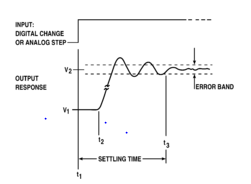



θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     8.88e-15 °C
Time constants: 
 [49936.089  4755.102   429.663   144.61 ] s 

2 x Time constants: 
 [99872.178  9510.204   859.327   289.22 ] s 

Maximum time step: 289.22 s = 4.82 min
dt = 240 s = 4 min
Time constants: 
 [49936.089  4755.102   429.663   144.61 ] s 

Settling time: 199744 s = 3329.1 min     = 55.48 h = 2.31 days
Duration = 900.0 s
Number of time steps = 3
u = 


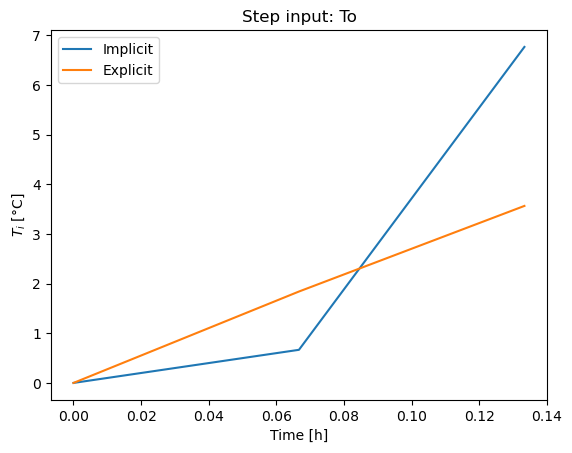

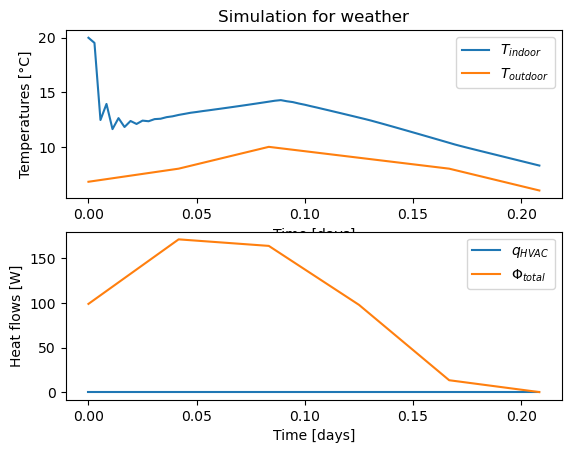

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 8.4217 °C
2000-01-03 12:00:00 	start date
2000-01-03 18:00:00 	end date


(None, None, None, None, None, None, None)

In [40]:
duration = 3600*0.25
code(duration)

- On the first graph (Step response to outdoor temperature by using Euler):

We changed the duration of 48h (initial simulation) in 0.25h=900s and we observe that the indoor temperature is not stabilised at 0.25h. The value of the indoor temperature is 5.4°C for 0.25h while in the steady state the temperature is stabilised around 10°C. Indeed by choosing a duration shorter than the settling time we cannot reach the steady state. The response is not stable. 

While on the initial graph (see figure 4) the value of the indoor temperature obtained after the settling time is almost equal to the value obtained in steady-state (we can see a stabilization of Ti). 




- On the second graph (Simulation for weather):
We modify the duration from one month to one day to have a better look at the influence of initials conditions.
 
We observe the indoor and outdoor temperatures, as we said before we show the results on 24h in order to better analyse the variation and the influence of initial conditions (20°C indoor). Our first hypothesis was that the results will be too influence by the initials conditions because of a duration of simulation shorter than the settlling time.

However we cannot see the influence of initial conditions with this graph, it is identical to the initial problem without modifications. Indeed the indoor temperature varies really quickly, in less than two hours the temperature decreased of 7°C.  In our case the room is controlled by a HVAC system, meanning that the room is ventilated. This explains why the indoor temperature is changing so fast even with a small duration of simulation, the ventilated air flow influence the indoor temperature (the flow does not have to pass through the wall). Indeed with the low capacity of the air the value of the indoor temperature varies really quickly thanks to the ventilated air flow, that is the reason why the initial temperature doesn't matter much here and the modification is not visible on the graph.

On the contrary, the temperature of the walls will varie more slowly due to its huge capacity, the initials conditions will have a large influence on the walls' temperature because of the low duration of simulation. 

- To illustrate that we can have a look at the model of a simple wall without HVAC system and glass:

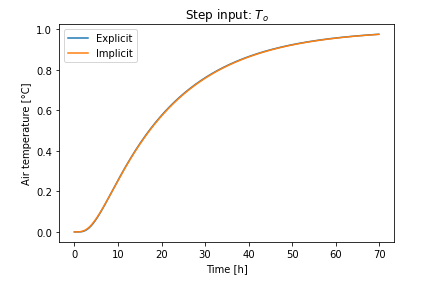
> figure 6: Step response to outdoor temperature $T_o$ obtained by Euler integration 

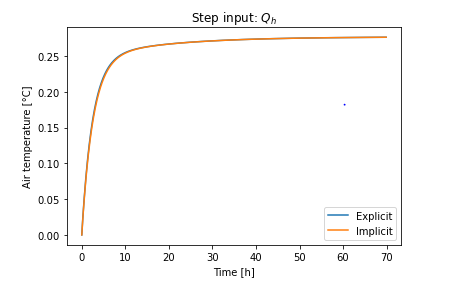
> figure 7: Step response to indoor heat flow rate $\dot{Q}_h$ obtained by Euler integration 

With those both graphs obtained by explicit and implicit Euler integration of the state-space model we can see the time difference needed to reach the steady state temperature. When the flow comes from oustide (and have to pass through the wall) the air need more time to have a stationnary temperature (50h on average, see figure 6) compare to the case with a direct indoor heat flow (only 20h to be stationnary, see figure 7).
It well illustrates the difference of capacity between the walls and the air.

We choose a simulation duration shorter than the response time and we saw that the steady state is not reach. So it is really important to choose a duration larger than the response time to reach the steady state and avoid an influence of initials conditions on the results.

## Influence of the step time

In this part, we study the ideal time step we can choose in order to have consistent results.

The time step needs to be smaller than the maximum time step.
$$ 0 < \Delta t < \min -2 / \lambda_i $$

The maximum time step depends on the values of the eigenvalues of matrix As.

### Maximum time step equal to 4.8 minutes

First, we study the influence of the time step on the results with a maximum time step equal to 4.82 minutes.
This maximum time step is obtained when we take into consideration the capacities of the air and the glass (we don't neglect them).
We study three different time steps : 4 minutes, 3 minutes and 1 minute.

- Time step dt = 4 minutes:

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     8.88e-15 °C
Time constants: 
 [49936.089  4755.102   429.663   144.61 ] s 

2 x Time constants: 
 [99872.178  9510.204   859.327   289.22 ] s 

Maximum time step: 289.22 s = 4.82 min
dt = 240 s = 4 min
Time constants: 
 [49936.089  4755.102   429.663   144.61 ] s 

Settling time: 199744 s = 3329.1 min     = 55.48 h = 2.31 days
Duration = 172800 s
Number of time steps = 720
u = 


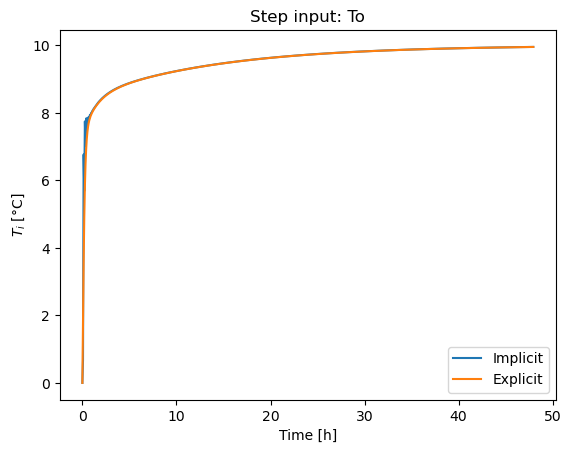

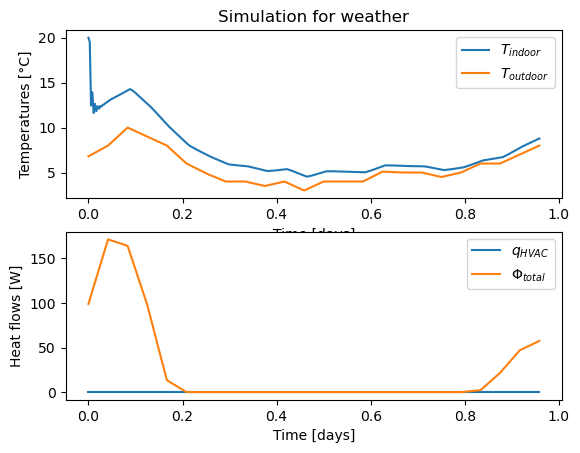

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 8.7177 °C
2000-01-03 12:00:00 	start date
2000-01-04 12:00:00 	end date


(None, None, None, None, None, None, None)

In [41]:
dt = 4*60  # seconds
code2(dt)

- Time step dt = 3 minutes

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     8.88e-15 °C
Time constants: 
 [49936.089  4755.102   429.663   144.61 ] s 

2 x Time constants: 
 [99872.178  9510.204   859.327   289.22 ] s 

Maximum time step: 289.22 s = 4.82 min
dt = 180 s = 3 min
Time constants: 
 [49936.089  4755.102   429.663   144.61 ] s 

Settling time: 199744 s = 3329.1 min     = 55.48 h = 2.31 days
Duration = 172800 s
Number of time steps = 960
u = 


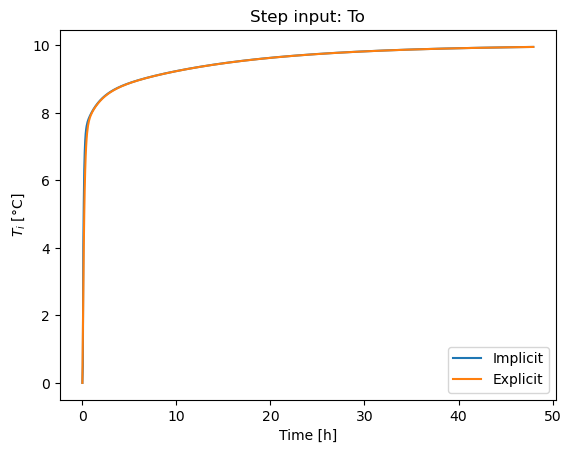

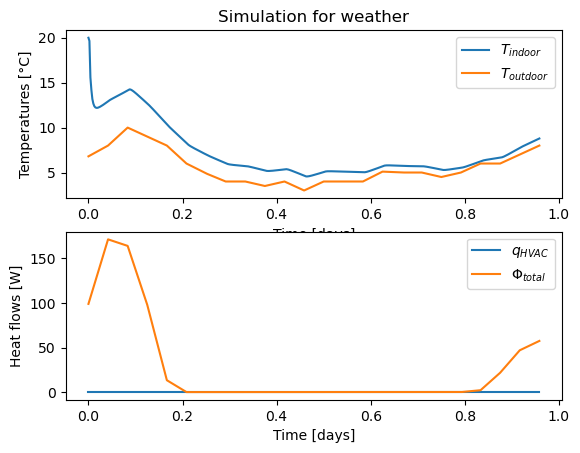

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 8.7358 °C
2000-01-03 12:00:00 	start date
2000-01-04 12:00:00 	end date


(None, None, None, None, None, None, None)

In [42]:
dt = 3*60 # seconds
code2(dt)

- Time step dt = 1 minute

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     8.88e-15 °C
Time constants: 
 [49936.089  4755.102   429.663   144.61 ] s 

2 x Time constants: 
 [99872.178  9510.204   859.327   289.22 ] s 

Maximum time step: 289.22 s = 4.82 min
dt = 60 s = 1 min
Time constants: 
 [49936.089  4755.102   429.663   144.61 ] s 

Settling time: 199744 s = 3329.1 min     = 55.48 h = 2.31 days
Duration = 172800 s
Number of time steps = 2880
u = 


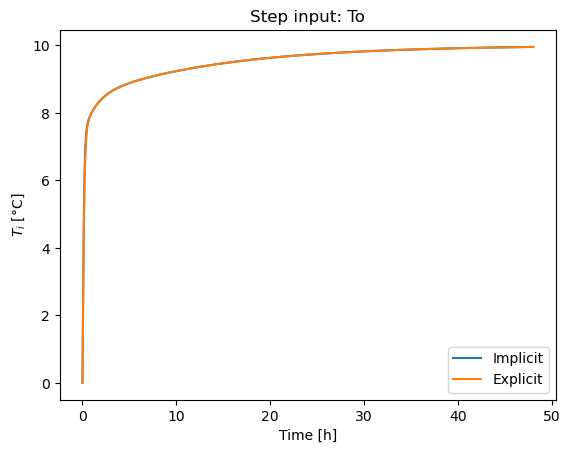

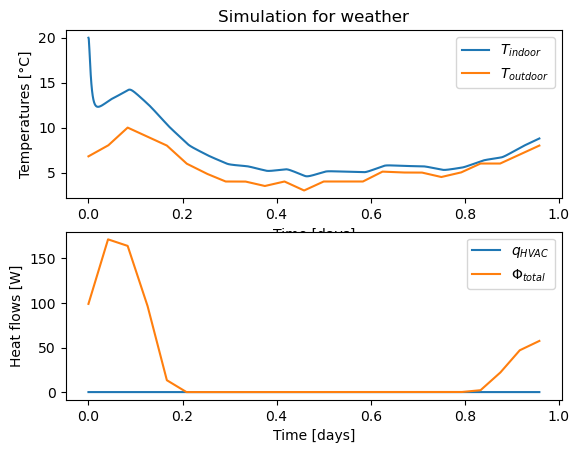

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 8.7719 °C
2000-01-03 12:00:00 	start date
2000-01-04 12:00:00 	end date


(None, None, None, None, None, None, None)

In [43]:
dt = 60 # seconds
code2(dt)

- Observations 


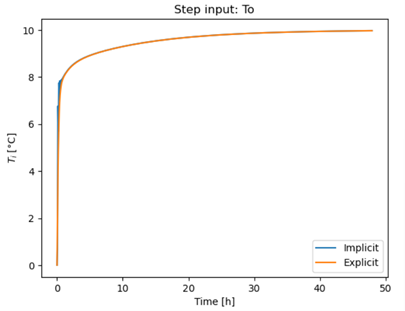
> Figure 8: Step response to outdoor temperature $T_o$ obtained by Euler integration for dt = 4 min

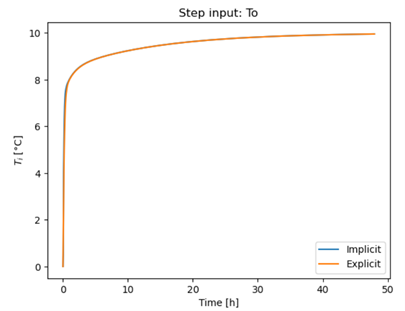
> Figure 9: Step response to outdoor temperature $T_o$ obtained by Euler integration for dt = 3 min

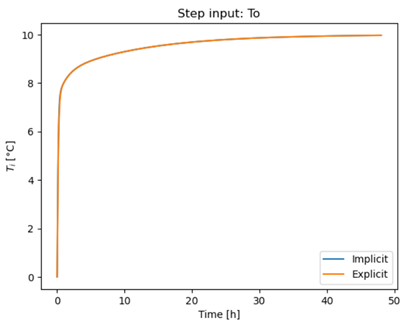
> Figure 10: Step response to outdoor temperature $T_o$ obtained by Euler integration for dt = 1 min


We observe that the time step has an influence on the results obtained with the implicit Euler method.
Comparing figures 8, 9 and 10, we observe that the smaller the time step, the closer the results obtained with the implicit Euler method are to the results obtained with the explicit Euler method.

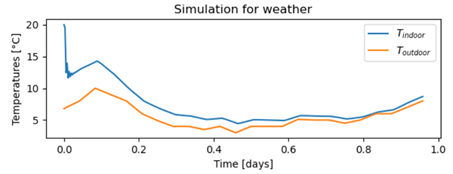
> Figure 11: Simulation in free-running with weather data using Euler explicit method of integration (indoor and outdoor temperatures) for dt = 4 min

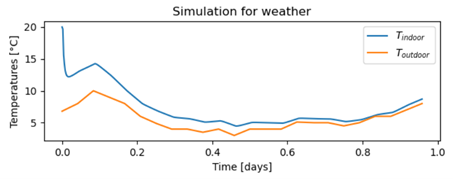
> Figure 12: Simulation in free-running with weather data using Euler explicit method of integration (indoor and outdoor temperatures) for dt = 3 min

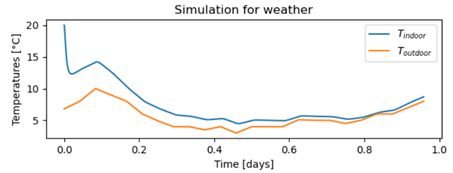
> Figure 13: Simulation in free-running with weather data using Euler explicit method of integration (indoor and outdoor temperatures) for dt = 1 min

Comparing figures 11, 12 and 13, we observe that the smaller the time step, the smoother the indoor temperature versus time curve.

With these eigenvalues (so a maximum time step equal to 4.8 minutes), a 3-minute time step seems ideal in order to have consistent results. We can observe on figure 9 that for a 3-minute time step, the results obtained with the implicit Euler method are really close to the results obtained with the explicit Euler method. We don't see a difference between figures 12 (dt = 3 minutes) and 13 (dt = 1 minute), so there's no need to choose a smaller time step than 3 minutes.

### Maximum time step equal to 156.7 min

Now, we change the maximum time step by neglecting the capacities of the air and the glass in the capacity matrix.

We study different time steps : 156 minutes, 100 minutes, 50 minutes, 40 minutes, 30 minutes and 1 minute.

- Time step dt = 156 minutes

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     1.78e-15 °C
Time constants: 
 [49933.665  4701.26 ] s 

2 x Time constants: 
 [99867.33   9402.519] s 

Maximum time step: 9402.52 s = 156.71 min
dt = 9360 s = 156 min
Time constants: 
 [49933.665  4701.26 ] s 

Settling time: 199735 s = 3328.9 min     = 55.48 h = 2.31 days
Duration = 172800 s
Number of time steps = 18
u = 


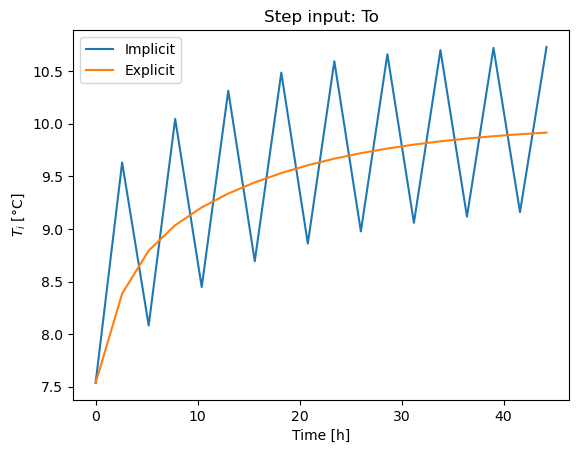

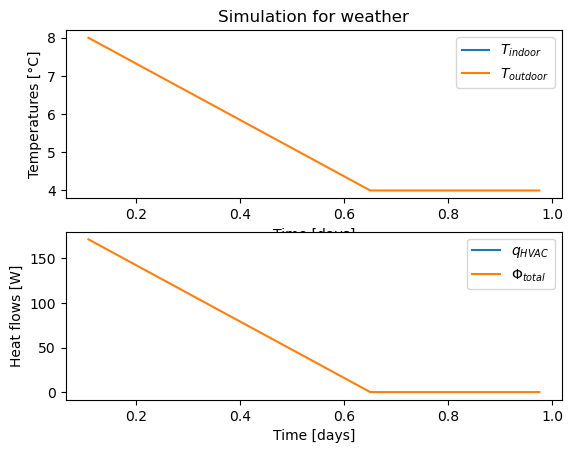

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: nan °C
2000-01-03 12:00:00 	start date
2000-01-04 12:00:00 	end date


(None, None, None, None, None, None, None)

In [44]:
dt = 156*60 # seconds
code3(dt)

- Time step dt = 100 minutes

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     1.78e-15 °C
Time constants: 
 [49933.665  4701.26 ] s 

2 x Time constants: 
 [99867.33   9402.519] s 

Maximum time step: 9402.52 s = 156.71 min
dt = 6000 s = 100 min
Time constants: 
 [49933.665  4701.26 ] s 

Settling time: 199735 s = 3328.9 min     = 55.48 h = 2.31 days
Duration = 172800 s
Number of time steps = 28
u = 


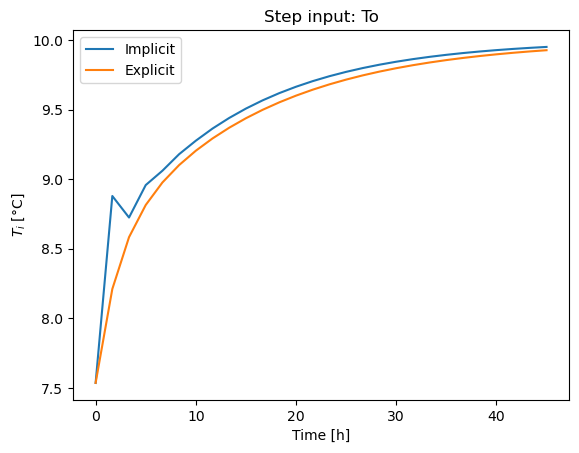

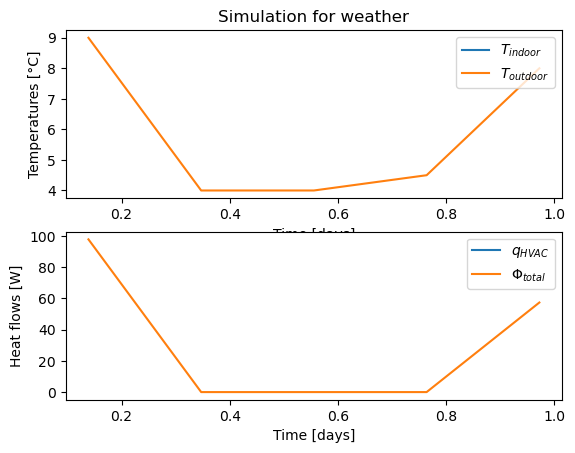

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: nan °C
2000-01-03 12:00:00 	start date
2000-01-04 12:00:00 	end date


(None, None, None, None, None, None, None)

In [45]:
dt = 100*60 # seconds
code3(dt)

- Time step dt = 50 minutes

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     1.78e-15 °C
Time constants: 
 [49933.665  4701.26 ] s 

2 x Time constants: 
 [99867.33   9402.519] s 

Maximum time step: 9402.52 s = 156.71 min
dt = 3000 s = 50 min
Time constants: 
 [49933.665  4701.26 ] s 

Settling time: 199735 s = 3328.9 min     = 55.48 h = 2.31 days
Duration = 172800 s
Number of time steps = 57
u = 


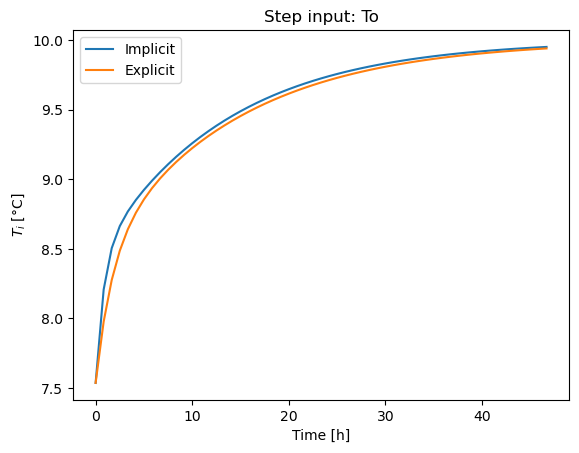

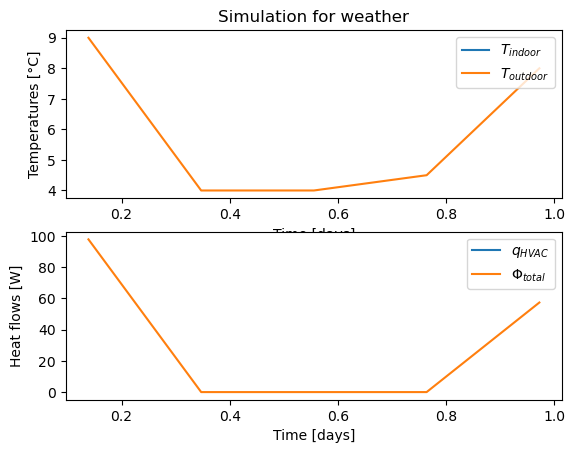

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: nan °C
2000-01-03 12:00:00 	start date
2000-01-04 12:00:00 	end date


(None, None, None, None, None, None, None)

In [46]:
dt = 50*60 # seconds
code3(dt)

- Time step dt = 40 minutes

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     1.78e-15 °C
Time constants: 
 [49933.665  4701.26 ] s 

2 x Time constants: 
 [99867.33   9402.519] s 

Maximum time step: 9402.52 s = 156.71 min
dt = 2400 s = 40 min
Time constants: 
 [49933.665  4701.26 ] s 

Settling time: 199735 s = 3328.9 min     = 55.48 h = 2.31 days
Duration = 172800 s
Number of time steps = 72
u = 


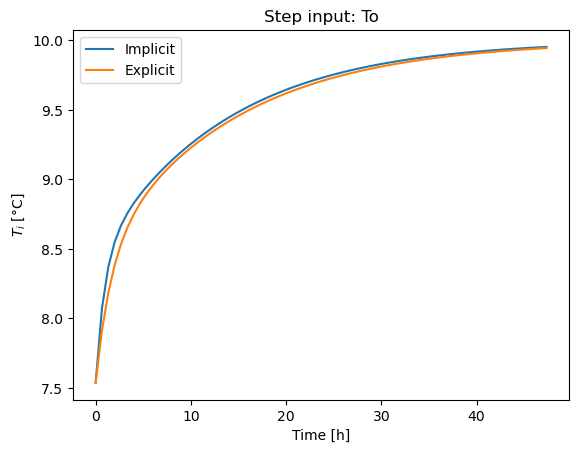

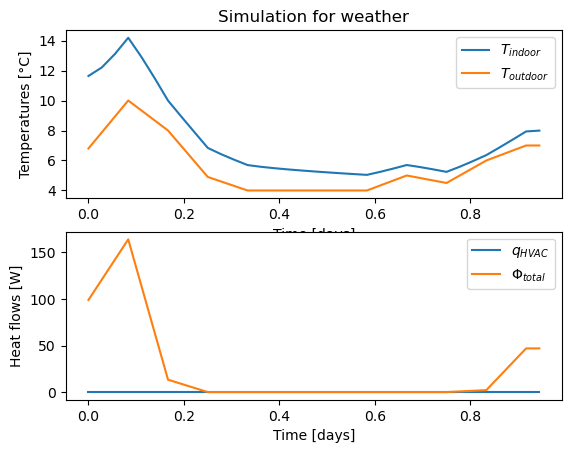

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 7.9373 °C
2000-01-03 12:00:00 	start date
2000-01-04 12:00:00 	end date


(None, None, None, None, None, None, None)

In [47]:
dt = 40*60 # seconds
code3(dt)

- Time step dt = 30 minutes

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     1.78e-15 °C
Time constants: 
 [49933.665  4701.26 ] s 

2 x Time constants: 
 [99867.33   9402.519] s 

Maximum time step: 9402.52 s = 156.71 min
dt = 1800 s = 30 min
Time constants: 
 [49933.665  4701.26 ] s 

Settling time: 199735 s = 3328.9 min     = 55.48 h = 2.31 days
Duration = 172800 s
Number of time steps = 96
u = 


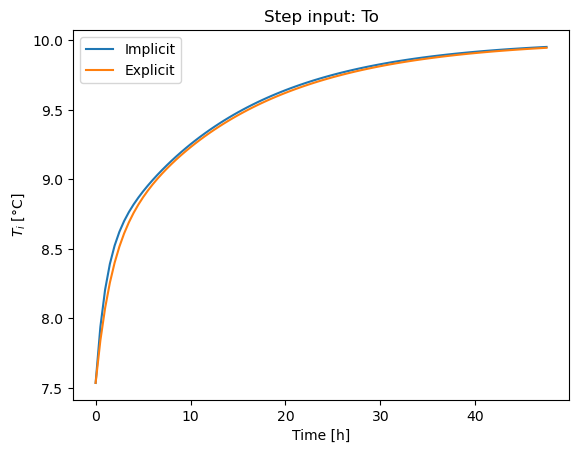

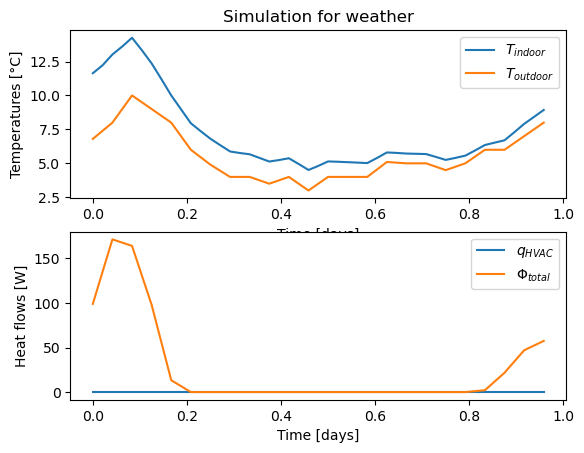

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 8.4175 °C
2000-01-03 12:00:00 	start date
2000-01-04 12:00:00 	end date


(None, None, None, None, None, None, None)

In [48]:
dt = 30*60 # seconds
code3(dt)

- Time step dt = 1 minute

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     1.78e-15 °C
Time constants: 
 [49933.665  4701.26 ] s 

2 x Time constants: 
 [99867.33   9402.519] s 

Maximum time step: 9402.52 s = 156.71 min
dt = 60 s = 1 min
Time constants: 
 [49933.665  4701.26 ] s 

Settling time: 199735 s = 3328.9 min     = 55.48 h = 2.31 days
Duration = 172800 s
Number of time steps = 2880
u = 


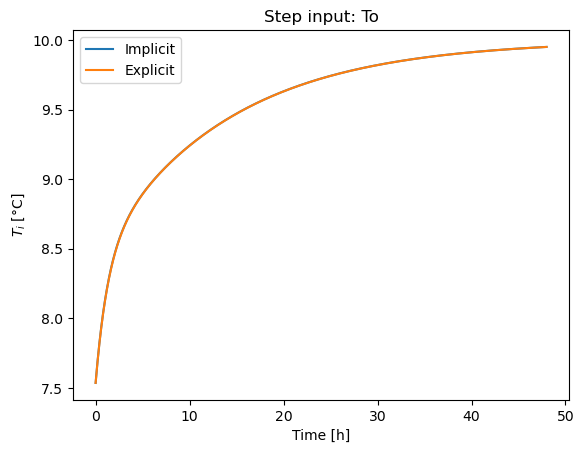

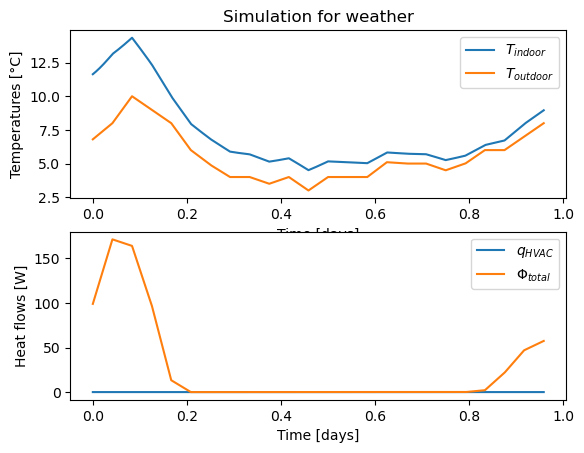

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 8.9416 °C
2000-01-03 12:00:00 	start date
2000-01-04 12:00:00 	end date


(None, None, None, None, None, None, None)

In [49]:
dt = 1*60 # seconds
code3(dt)

- Observations

As previously, we observe that the smaller the time step, the closer the results obtained with the implicit Euler method are to the results obtained with the explicit Euler method.
From a time step of less than 30 minutes, we observe that the results obtained with the implicit Euler method are very close to those obtained with the explicit method.


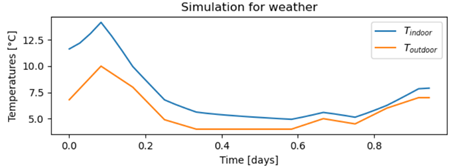
> Figure 14: Simulation in free-running with weather data using Euler explicit method of integration (indoor and outdoor temperatures) for dt = 40 min

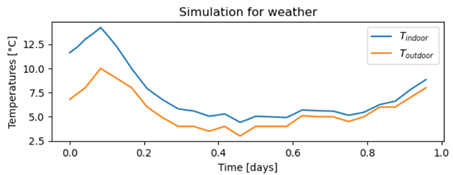
> Figure 15: Simulation in free-running with weather data using Euler explicit method of integration (indoor and outdoor temperatures) for dt = 30 min

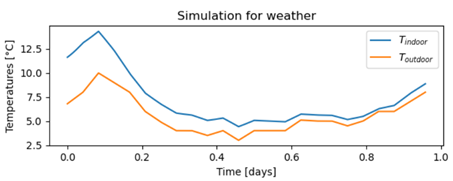
> Figure 16: Simulation in free-running with weather data using Euler explicit method of integration (indoor and outdoor temperatures) for dt = 1 min

We observe that from a time step lower than 30 min, the curve of the indoor temperature versus time stabilizes (we don't see a difference between figures 15 and 16).

With these eigenvalues (so a maximum time step equal to 156.7 minutes), a 30-minute time step seems ideal in order to have consistent results. With a 30-minute time step, the results obtained with the implicit Euler method are really close to the results obtained with the explicit Euler method and the curve of the indoor temperature versus time is the same as for a 1-minute time step.

### Influence of the maximum time step

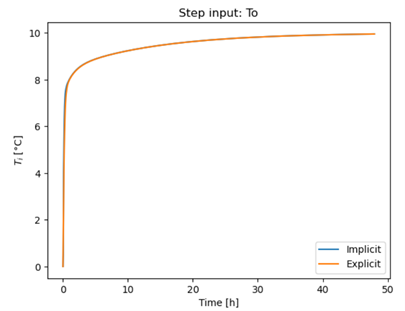
> Figure 17: Step response to outdoor temperature $T_o$ obtained by Euler integration for a maximum time step equal to 4.8 minutes (for dt = 3 min)

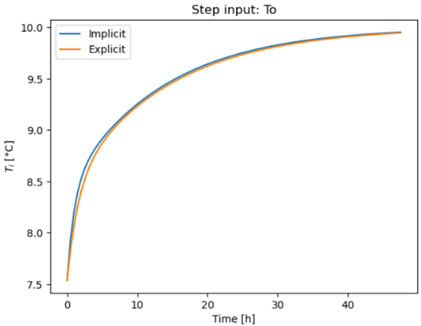
> Figure 18: Step response to outdoor temperature $T_o$ obtained by Euler integration for a maximum time step equal to 156.7 minutes (for dt = 30 min)


Comparing the step response to outdoor temperature using Euler implicit and explicit integration for a maximum time step of 4.8 minutes and 156.7 minutes (figures 17 and 18), we can compare the time difference needed to reach the steady state temperature. When the capacities of the air and the glass are neglected, it takes more time for the air to reach a stationary temperature (40h see figure 18) than when the capacities of the air and the glass aren’t neglected (20h see figure 17). The glass allows a quick response, it's very effective.

## Replacing concrete by biosourced materials

In the previous sections, we managed to understand the aim of the settling time and we obtained a good step time for the modelisation.
In this part, we study the influence of the materials on the indoor temperature and on the settling time.
We know that biosourced materials might have a key-role in the future of construction, and wood is often refered as a good solution. So, we want to observe the thermical impact of the materials, by using wood instead of concrete.

We changed the conductivity, the density, the specific heat and the emissivity factor of the material.

- Use of pine wood instead of concrete

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     5.51e-14 °C
Time constants: 
 [168448.852   5844.816    429.645    144.281] s 

2 x Time constants: 
 [336897.705  11689.633    859.29     288.562] s 

Maximum time step: 288.56 s = 4.81 min
dt = 240 s = 4 min
Time constants: 
 [168448.852   5844.816    429.645    144.281] s 

Settling time: 673795 s = 11229.9 min     = 187.17 h = 7.80 days
Duration = 777600 s
Number of time steps = 3240


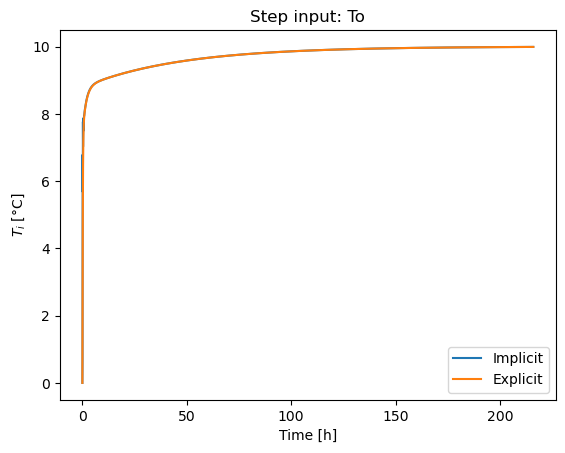

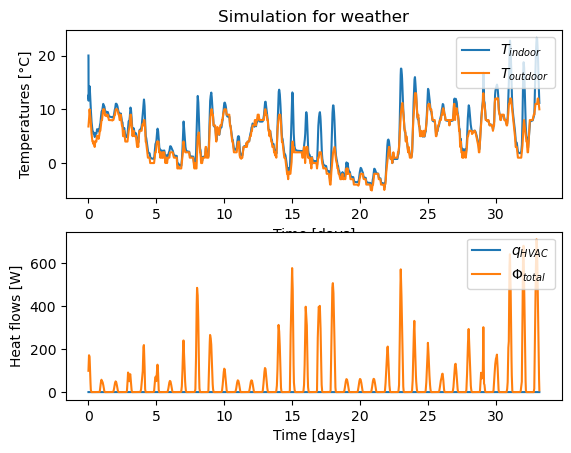

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 11.3740 °C
2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


(None, None, None, None, None, None, None)

In [50]:
Conductivity_pine = 0.12 # W/(m·K)
Density_pine = 500 # kg/m³
Specific_heat_pine = 2301 # J/(kg·K)
Emissivity_pine = 0.90 

material(Conductivity_pine, Density_pine, Specific_heat_pine, Emissivity_pine)

We can observe an increase of the settling time, which corresponds to the time of response of the model. Now, it takes 7,8 days for the model so the Initial Conditions don't have an incidence on the temperature modelisation. As a result, we need to increase the modelisation time (settling time) so the steady-state indoor temperature is the closest possible of the steady-state response. 
The increase of the settling time means that in this configuration, it takes 4 times as long for the model to reach the steady-state : the inertia of the model is increased, which is good if we consider that the bigger the inertia is, the better it is for the comfort. The house will keep more the calories.

- Use of oak wood instead of concrete

Oak wood is used in mountain regions of France, to build chalet-style houses for example. It's a massive wood which also has good mechanical properties.

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     6.57e-14 °C
Time constants: 
 [182873.203   5546.965    429.795    144.825] s 

2 x Time constants: 
 [365746.406  11093.931    859.591    289.649] s 

Maximum time step: 289.65 s = 4.83 min
dt = 240 s = 4 min
Time constants: 
 [182873.203   5546.965    429.795    144.825] s 

Settling time: 731493 s = 12191.5 min     = 203.19 h = 8.47 days
Duration = 777600 s
Number of time steps = 3240


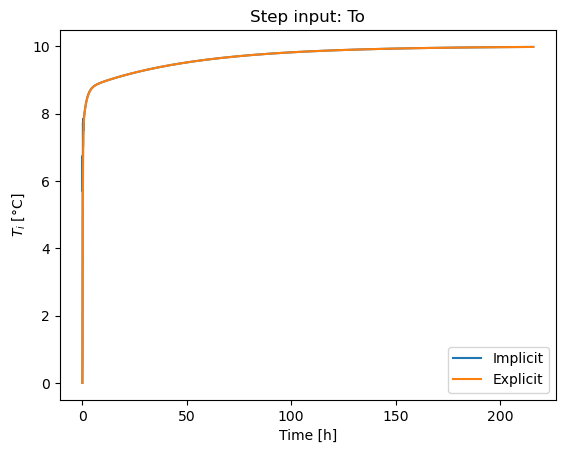

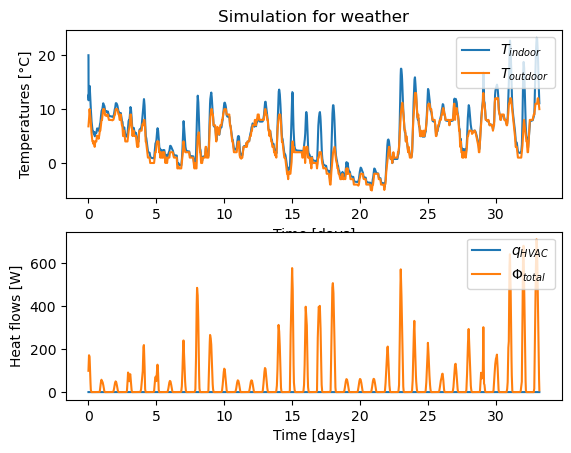

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 11.2803 °C
2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


(None, None, None, None, None, None, None)

In [51]:
Conductivity_oak = 0.17 # W/(m·K)
Density_oak = 700 # kg/m³
Specific_heat_oak = 2385 # J/(kg·K)
Emissivity_oak = 0.82 

material(Conductivity_oak, Density_oak, Specific_heat_oak, Emissivity_oak)

We can observe an increase of the settling time, which corresponds to the time of response of the model. 
Now, it takes 8,47 days for the model so the Initial Conditions don't have an incidence on the 
temperature modelisation. This is logical compared to the pine wood, because the oak wood is heavier and its density is almost the double so the thermical inertia of the material is better. When we increase the settling time so the model will reach the steady-state, the state space response is 11,28°C compared to the 10°C of the space model, so the difference is a bit larger but it remains a good modelisation.

By changing the material, it takes more time to reach that the indoor temperature required, but once it's reached, the indoor temperature of the house will be less affected by the changes of outdoor temperature. This is a good point for the comfort.
However, in reality we don't put as much wood as concrete in a house : so the inertia of the house will be reduced.So, we will try to modelise a realistic wood structure.

- Changing the thickness

In this part, we will change the thickness of the material in order to be more realistic. As we said earlier the thickness of the concrete and of the wood are not the same. A wood structure is five times lighter than a concrete structure. Generally, the thickness is around 10 cm for a full structure of wood (source : Leroy Merlin).

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     1.07e-14 °C
Time constants: 
 [51851.367  5091.777   429.763   144.824] s 

2 x Time constants: 
 [103702.734  10183.554    859.526    289.649] s 

Maximum time step: 289.65 s = 4.83 min
dt = 240 s = 4 min
Time constants: 
 [51851.367  5091.777   429.763   144.824] s 

Settling time: 207405 s = 3456.8 min     = 57.61 h = 2.40 days
Duration = 777600 s
Number of time steps = 3240


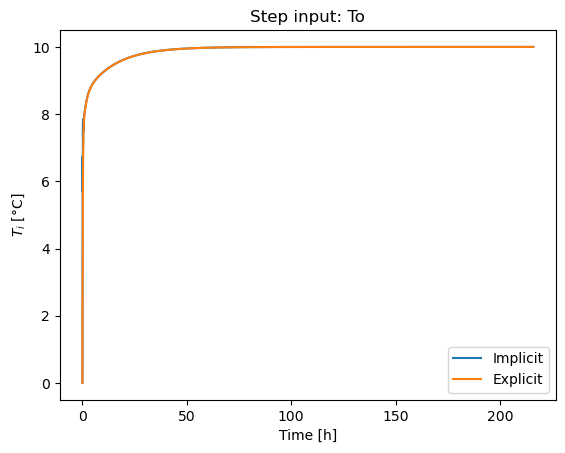

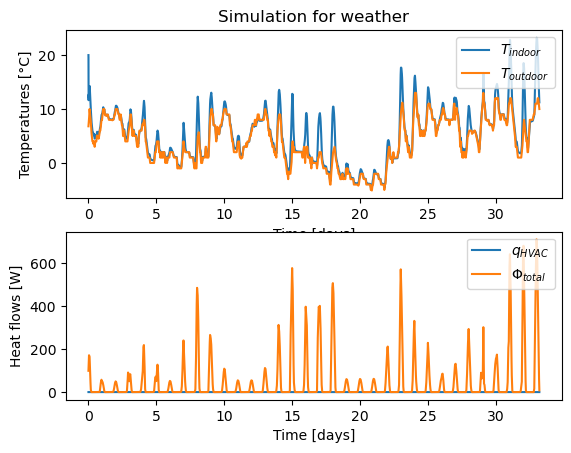

- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 11.4310 °C
2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


(None, None, None, None, None, None, None)

In [52]:
Conductivity_oak = 0.17 # W/(m·K)
Density_oak = 700 # kg/m³
Specific_heat_oak = 2385 # J/(kg·K)
Emissivity_oak = 0.82 
width_oak = 0.1 #m

width (Conductivity_oak, Density_oak, Specific_heat_oak, Emissivity_oak, width_oak)

We can notice a huge change of the settling time : we got back to 2.40 days, which is really close to the initial situation, with the concrete. It's logical that reducing the thickness of the wood will reduce the insulation so the inertia of the building is reduced. What is interesting is that using twice less wood than concrete, it takes the same time for the cube to reach the steady-state. The inertia of the building is reduced and it needs more insulation in order to be comfortable. We can link these tests with the chalet-style house in the Alps, where most of them have a wood surface outdoor and behind there is a concrete structure for the mechanical parts. They can mix the thermical properties of the concrete and the wood which gives to the house a good inertia.

For the cubic building, in order to have a better insulation, we could change the isulating materials or to use different kinds of materials.

​

## Thermal inertia and latency

In this last part, we want to obtain a latency between the reach time of the exterior max temperature and the interior max temperature, and more importantly we want to understand what affects this latency. This  might be interesting because it allows a gain of energy and confort. In order to do this, we are going to run our model changing only one particular value each time, even if it's not realistic.

The latency between indoor and outdoor max temperatures is caused by the thermal capacity of materials, storing freshness during the night and releasing it during the day in summer, and vice-versa in winter. However, the materials change in the previous part changed their thermal capacity but did not induce any latency. Our hypothesis is that the thermal flux caused by the air change, the solar radiation or the materials conduction might bypass the previously presented phenomenon if too high. Therefore, we've come to study the latency regarding not only the thermal capacity of materials, but also the air change rate, the window transmittance and the conductance of materials. Appart for the transmittance, inherent to the window, we hypotethized at first that every material had the same impact, so we only changed the conductivity (changing the conductance and only the conductance in our model) and density (changing the thermal capacity and only the thermal capacity in our model) of the concrete layer of the walls (arbitrary choice). We are using the function latency(Conduct, Dens, Transm, AirCh) defined in the beginning of this analysis, running our model with different values of ACH, τ_gSW, concrete conductivity and density. This function returns results for a one day period in august, in order to see precisely the latency.

For example, this is the output of the latency function with normal values of the initial model :

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     8.88e-15 °C
Time constants: 
 [43971.968  4752.052   429.663   144.61 ] s 

2 x Time constants: 
 [87943.936  9504.104   859.327   289.22 ] s 

Maximum time step: 289.22 s = 4.82 min
dt = 240 s = 4 min
Time constants: 
 [43971.968  4752.052   429.663   144.61 ] s 

Settling time: 175888 s = 2931.5 min     = 48.86 h = 2.04 days
Duration = 777600 s
Number of time steps = 3240


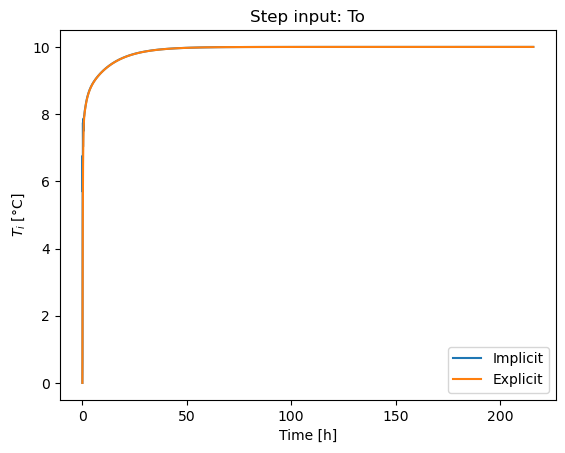

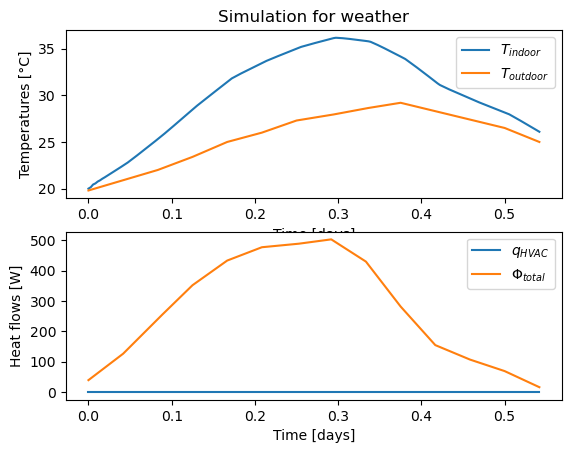

In [53]:
latency (1.4, 2300, 0.3, 1)

The latency we want to study appears on the "Simulation for weather" first graph, Temperatures on Time. Here we can read a latency around -0.08 days. The indoor max temperature is indeed reached before the outdoor max temperature, which is a very bad performance.

Let's now try a lower conductivity

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     2.84e-14 °C
Time constants: 
 [1.449e+08 1.109e+04 4.299e+02 1.446e+02] s 

2 x Time constants: 
 [2.899e+08 2.218e+04 8.598e+02 2.892e+02] s 

Maximum time step: 289.22 s = 4.82 min
dt = 240 s = 4 min
Time constants: 
 [1.449e+08 1.109e+04 4.299e+02 1.446e+02] s 

Settling time: 579734887 s = 9662248.1 min     = 161037.47 h = 6709.89 days
Duration = 777600 s
Number of time steps = 3240


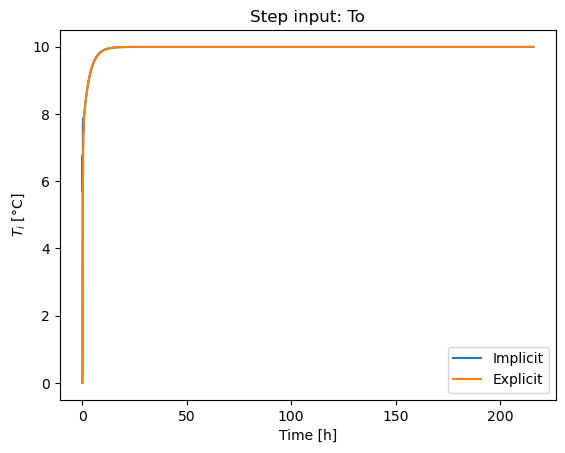

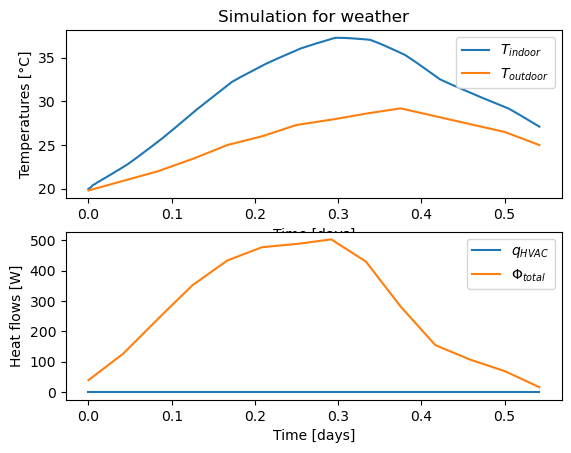

In [54]:
latency(0.00014, 2300, 0.3, 1)

This does not clearly change the latency, even though the new conductivity is unreallistically low.

Let's now try to change the density, for example a hundred times higher.

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     8.88e-15 °C
Time constants: 
 [4376115.322    4774.942     429.664     144.61 ] s 

2 x Time constants: 
 [8752230.643    9549.885     859.327     289.22 ] s 

Maximum time step: 289.22 s = 4.82 min
dt = 240 s = 4 min
Time constants: 
 [4376115.322    4774.942     429.664     144.61 ] s 

Settling time: 17504461 s = 291741.0 min     = 4862.35 h = 202.60 days
Duration = 777600 s
Number of time steps = 3240


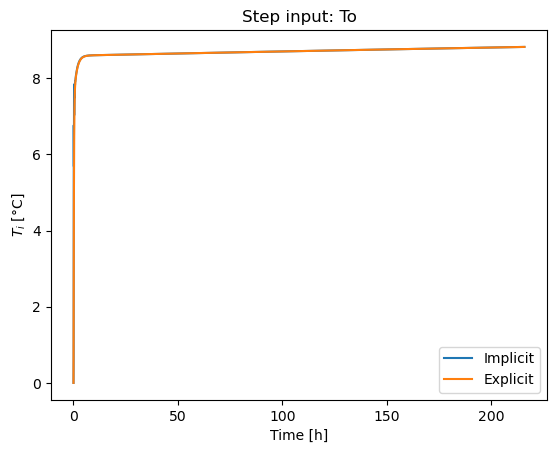

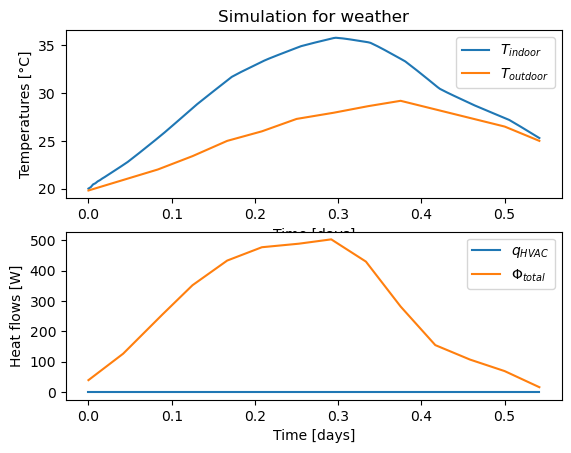

In [55]:
latency (1.4, 230000, 0.3, 1)

This does not clearly change the latency either.

Let's now try to change the transmittance, for example to zero.

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     8.88e-15 °C
Time constants: 
 [43971.968  4752.052   429.663   144.61 ] s 

2 x Time constants: 
 [87943.936  9504.104   859.327   289.22 ] s 

Maximum time step: 289.22 s = 4.82 min
dt = 240 s = 4 min
Time constants: 
 [43971.968  4752.052   429.663   144.61 ] s 

Settling time: 175888 s = 2931.5 min     = 48.86 h = 2.04 days
Duration = 777600 s
Number of time steps = 3240


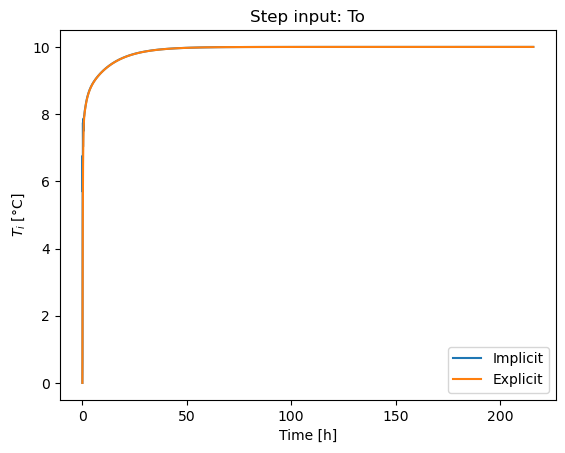

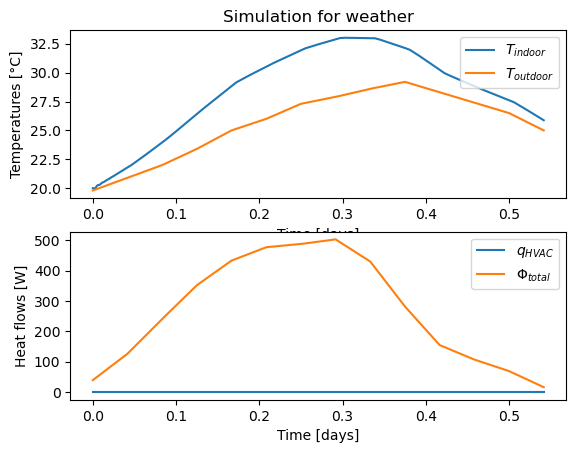

In [56]:
latency (1.4, 2300, 0, 1)

This does not clearly change the latency either.

Let's at last try to change the air change rate, for example to zero.

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     8.88e-15 °C
Time constants: 
 [43998.672  4818.735   460.223   147.17 ] s 

2 x Time constants: 
 [87997.344  9637.469   920.447   294.341] s 

Maximum time step: 294.34 s = 4.91 min
dt = 240 s = 4 min
Time constants: 
 [43998.672  4818.735   460.223   147.17 ] s 

Settling time: 175995 s = 2933.2 min     = 48.89 h = 2.04 days
Duration = 777600 s
Number of time steps = 3240


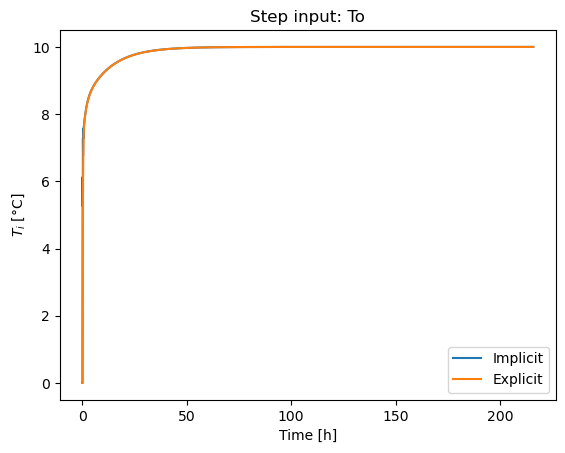

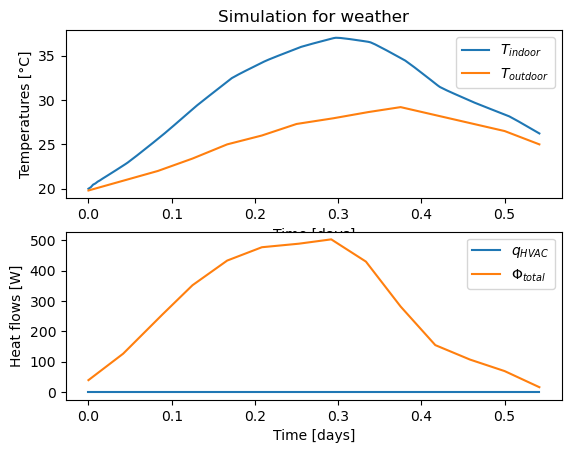

In [57]:
latency (1.4, 2300, 0.3, 0)

This still does not clearly change the latency.

Let's try to change them all at once.

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     1.95e-14 °C
Time constants: 
 [1.447e+17 1.146e+04 4.606e+02 1.472e+02] s 

2 x Time constants: 
 [2.894e+17 2.292e+04 9.211e+02 2.943e+02] s 

Maximum time step: 294.34 s = 4.91 min
dt = 240 s = 4 min
Time constants: 
 [1.447e+17 1.146e+04 4.606e+02 1.472e+02] s 

Settling time: 578721382704613376 s = 9645356378410222.0 min     = 160755939640170.38 h = 6698164151673.77 days
Duration = 777600 s
Number of time steps = 3240


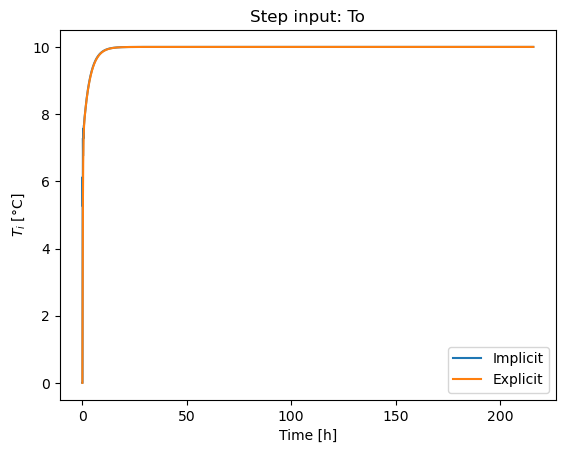

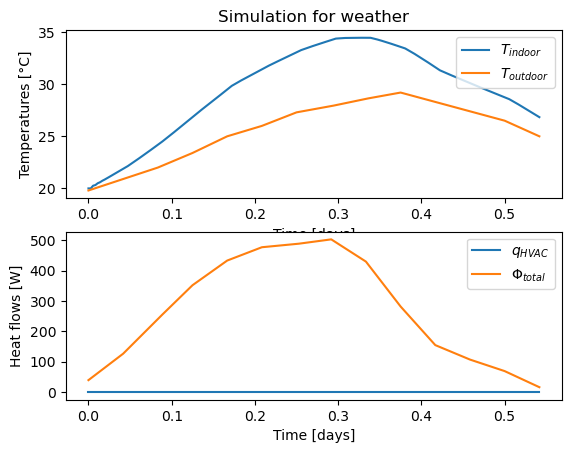

In [58]:
latency(0.000014, 230000000000, 0, 0)

The latency still does not clearly change.

At this point, we have to review our hypothesis. One idea is that maybe all materials do not have the same impact, and we shouldn't only change the concrete values. Let's now try to  change the worst values about thermal capacities and conductances rather than the concrete values : the insulation density and the glass width (this is still very unreallistic, but aims to point out what values are important about latency). That's what the new function latency2 does, as you can see in the definition section. With this, we do the same tests as we did with the first latency function.

Insulation density change :

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     7.11e-15 °C
Time constants: 
 [   42084.955 49086712.605      434.322      144.704] s 

2 x Time constants: 
 [   84169.909 98173425.209      868.645      289.408] s 

Maximum time step: 289.41 s = 4.82 min
dt = 240 s = 4 min
Time constants: 
 [   42084.955 49086712.605      434.322      144.704] s 

Settling time: 196346850 s = 3272447.5 min     = 54540.79 h = 2272.53 days
Duration = 777600 s
Number of time steps = 3240


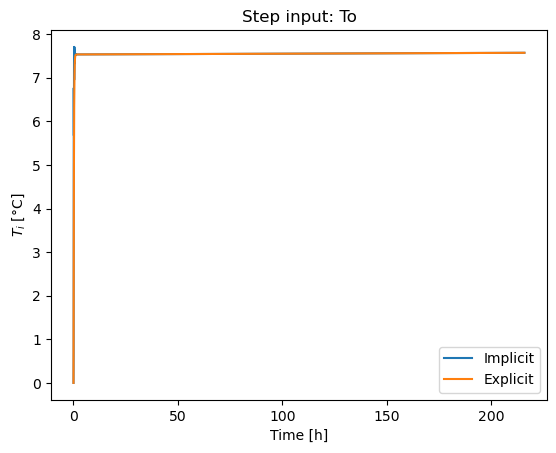

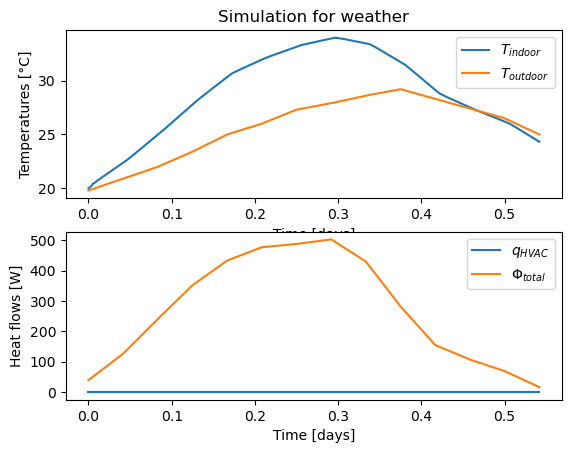

In [59]:
latency2(550000, 0.004, 0.3, 1)

Glass width change :

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     5.33e-15 °C
Time constants: 
 [   421.74    5094.495  43996.183 106332.409] s 

2 x Time constants: 
 [   843.48   10188.99   87992.366 212664.818] s 

Maximum time step: 843.48 s = 14.06 min
dt = 240 s = 4 min
Time constants: 
 [   421.74    5094.495  43996.183 106332.409] s 

Settling time: 425330 s = 7088.8 min     = 118.15 h = 4.92 days
Duration = 777600 s
Number of time steps = 3240


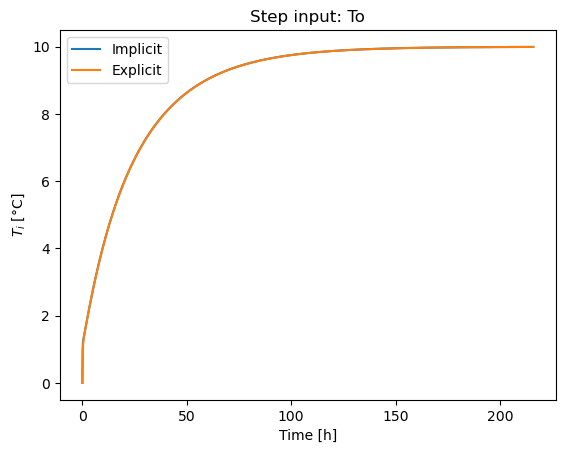

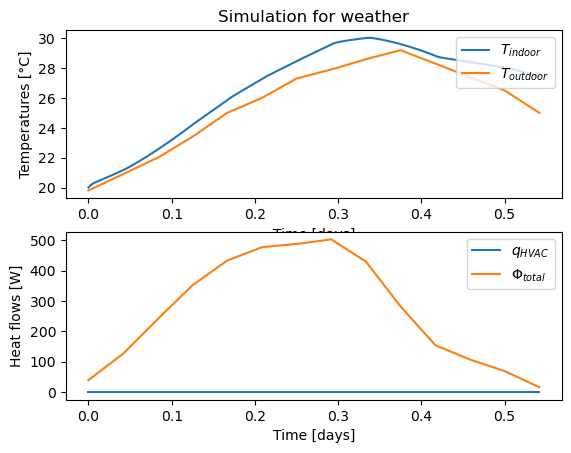

In [60]:
latency2(55, 0.4, 0.3, 1)

Change of insulation density, window width, transmittance, and air change all at once :

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
yss = [10.] °C
Max error between DAE and state-space:     7.11e-15 °C
Time constants: 
 [    487.902   42071.932 6040803.066  101692.829] s 

2 x Time constants: 
 [     975.804    84143.863 12081606.131   203385.657] s 

Maximum time step: 975.80 s = 16.26 min
dt = 240 s = 4 min
Time constants: 
 [    487.902   42071.932 6040803.066  101692.829] s 

Settling time: 24163212 s = 402720.2 min     = 6712.00 h = 279.67 days
Duration = 777600 s
Number of time steps = 3240


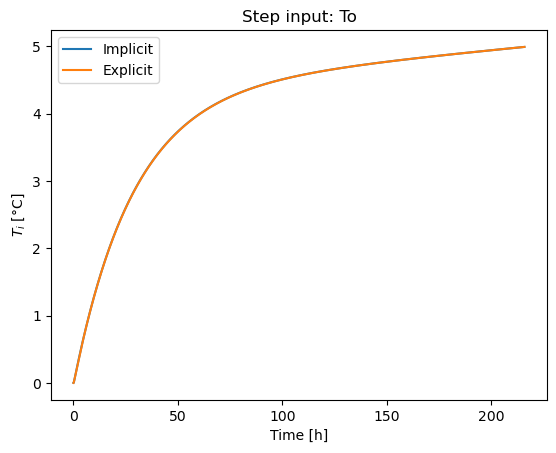

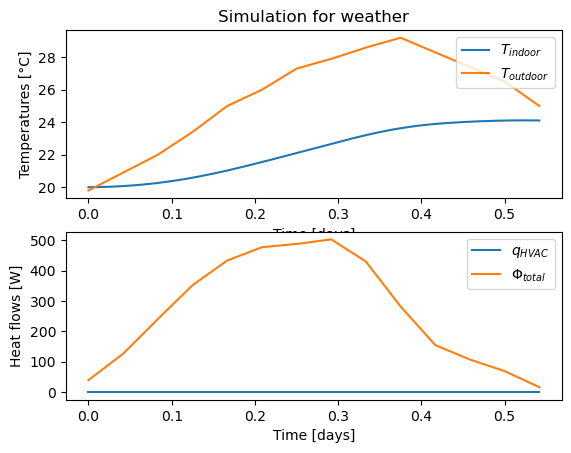

In [64]:
latency2(55000, 0.4, 0, 0)

As we can see, the latency finally changes when we change the glass width, thus its conductance. The latency changes even more when we change all values at once. This seems to show that the worst material's conductance is an important factor of the latency, and even prevents the other factors to have their effects, because they did not clearly changed the latency but still increased the change initiated by the window width change. We can indeed imagine that the heat will always come inside from the outside too fast if any part of the building is conducting too much, or if the air is changing too much, or the sun radiating too much inside, whatever the thermal capacities are.

We did not talk about it as it was not the goal of this study, but you could also see that thermal capacities greatly changed the settling time, because a greater thermal capacity makes it longer to reach a normal temperature if it was at a different initial temperature.

Of course this study is quite limited as it is short and unreallistic, even if it has still shown that latency requires that there is no high conductance nor probably high transmittance nor ventilation. It would be interesting in other studies to complete and verify this with the test of higher radiation values or air change values when the latency is good. It would also be interesting to do the same as this in winter conditions, to identify any difference. This could then be applied to more complex buildings with more realistic values in order to effectively optimize the latency, thus the confort and the energy consumption.